<a href="https://colab.research.google.com/github/t1p0kgod/DeepLearn/blob/main/work8/%D0%97%D0%BE%D0%BB%D0%BE%D1%82%D0%BA%D0%BE%D0%B2_%D0%A0%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №8. Генеративно-состязательная сеть (GAN). Часть 1**

[**Ссылка на код с пары**](https://colab.research.google.com/drive/1i3NlGFJbY6hvm-ropSFobW9_nqUcqzPS?usp=sharing)

# Примечание:

Не забывайте периодически сохранять параметры модели. Функции для этого описаны в теоретической части. В случае приостановки процесса обучения из-за перегрузки ОЗУ, Вы сможете загрузить последние предобученные параметры и продолжить обучение.

# **Задание №1.** Обучите генератор воспризводить примитивные изображения. Датасет выберите по желанию. ([Пример](https://www.kaggle.com/datasets/sagyamthapa/handwritten-math-symbols))

In [ ]:
!pip install umap-learn[plot]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

import warnings , os
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import umap
import umap.plot

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
img_rows = 28
img_cols = 28
channels = 1

# input image dimension
img_shape = (img_rows, img_cols, channels)

# size of noise vector to be used as generator input
z_dim = 100

In [ ]:
def build_generator(z_dim):
    model = Sequential()
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))
    model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
    model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))

    return model

In [ ]:
def build_discriminator(img_shape):
    model = Sequential()
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    model.add(LeakyReLU(alpha=0.01))

    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               padding='same'))

    model.add(LeakyReLU(alpha=0.01))

    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               padding='same'))

    model.add(LeakyReLU(alpha=0.01))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
def build_gan(generator, discriminator):
    model = Sequential()

    # Genearator -> Discriminator
    model.add(generator)
    model.add(discriminator)

    return model

In [ ]:
# Creating and Compiling discriminator Models
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])
# Preserve the parameters of the discriminator while training the generator
discriminator.trainable = False


In [ ]:
# Create a generator model
generator = build_generator(z_dim)

# Create and compile a GAN model with frozen discriminators to train the generator
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

    (x_train, y_train), (_, _) = mnist.load_data()

    X_train = x_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    real = np.ones((batch_size, 1))

    fake = np.zeros((batch_size, 1))

    for iteration in range(iterations):
        # -------------------------
        #  Discriminant training
        # -------------------------

        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        z = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(z)

        d_loss_real = discriminator.train_on_batch(imgs, real)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---------------------
        #  Training generator
        # ---------------------

        z = np.random.normal(0, 1, (batch_size, 100))
        
        if iteration == 0:
            print("\nRandom noise input image")
            sample_images(x_train[idx],y_train[idx],generator)            

        g_loss = gan.train_on_batch(z, real)

        if iteration < 200 and (iteration + 1) % 20 == 0:

            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, accuracy: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(x_train[idx],y_train[idx],generator)
            
        elif (iteration + 1) % sample_interval == 0:

            losses.append((d_loss, g_loss))
            accuracies.append(100.0 * accuracy)
            iteration_checkpoints.append(iteration + 1)

            print("%d [D loss: %f, accuracy: %.2f%%] [G loss: %f]" %
                  (iteration + 1, d_loss, 100.0 * accuracy, g_loss))

            sample_images(x_train[idx],y_train[idx],generator)

In [ ]:
image_grid_rows=4
image_grid_columns=4
    
def plot_dim_reduction(imgs, gen_imgs, img_labels):
    sns.set(style="ticks", context="talk",font_scale = 1)
    plt.style.use("dark_background")
    markers=['o','v','^','<','>','8','s','P','*','X','+','*']    
    plt.figure(figsize=(9,9))
    reshape_real_imgs = imgs.reshape(imgs.shape[0], -1)
    reshape_gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], -1)*255
    concat_imgs = np.concatenate([reshape_real_imgs,reshape_gen_imgs])
    fake_label = np.empty((image_grid_rows * image_grid_columns))
    fake_label[:] = 11
    concat_label = np.concatenate([img_labels,fake_label])
    mapper = umap.UMAP().fit_transform(concat_imgs)
    for i,marker in enumerate(markers):
        mask = concat_label == i
        if i == 11:
            plt.scatter(mapper[mask, 0], mapper[mask, 1], label=i, s=100, alpha=1,marker=marker, c ='yellow')
        else:
            plt.scatter(mapper[mask, 0], mapper[mask, 1], label=i, s=10, alpha=1,marker=marker)
    plt.legend(bbox_to_anchor=(1.00, 1), loc='upper left',fontsize=15)     
    plt.title("Plotting real and generated images after dimension reduction",fontsize = 15)

In [ ]:
def plot_dist(gen_imgs):
    sns.set(style="ticks", context="talk",font_scale = 1)
    plt.style.use("dark_background")
    plt.figure(figsize=(10,6))
    sns.distplot(gen_imgs,color='purple',kde=True)
    plt.title("Generated Images Distribution",fontsize = 20)
    plt.show()

In [ ]:
def sample_images(imgs, img_labels, generator):
    # random noise sampling
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))
    
    # Generate Image from Random Noise
    gen_imgs = generator.predict(z)  
    
    # Scale image pixel values between [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    plot_dim_reduction(imgs, gen_imgs, img_labels)
    plot_dist(gen_imgs)

    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(11, 11),
                            sharey=True,
                            sharex=True)

    cnt = 0
    #plt.figure(figsize=(9,9))
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='Greys_r')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

In [ ]:
# Setting Hyperparameter
iterations = 3201
batch_size = 128
sample_interval = 400

4/4 [==============================] - 6s 3ms/step

Random noise input image
1/1 [==============================] - 0s 214ms/step


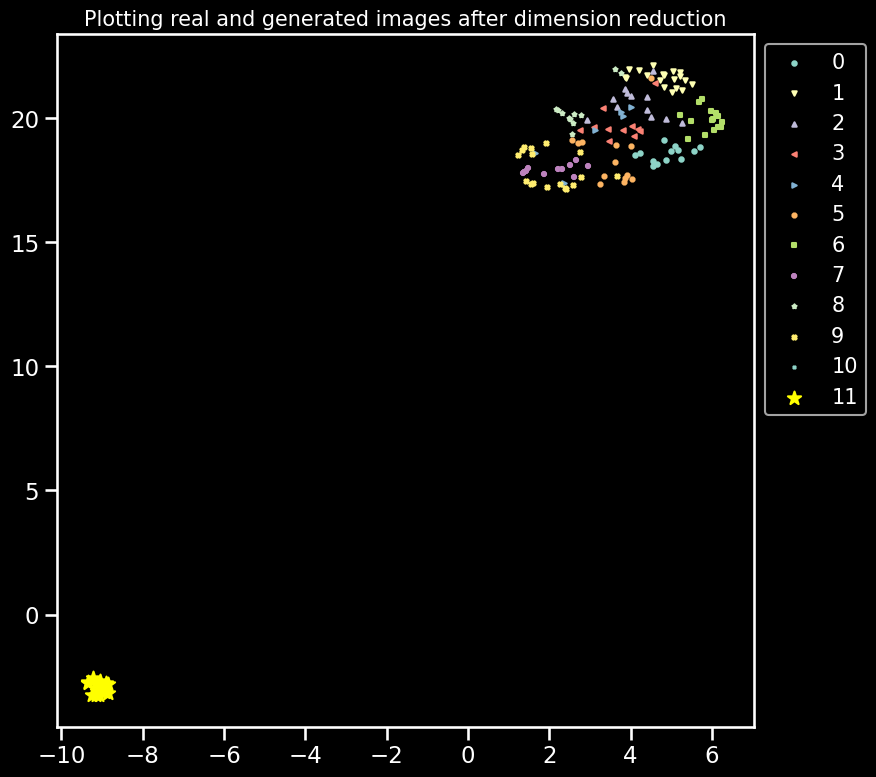

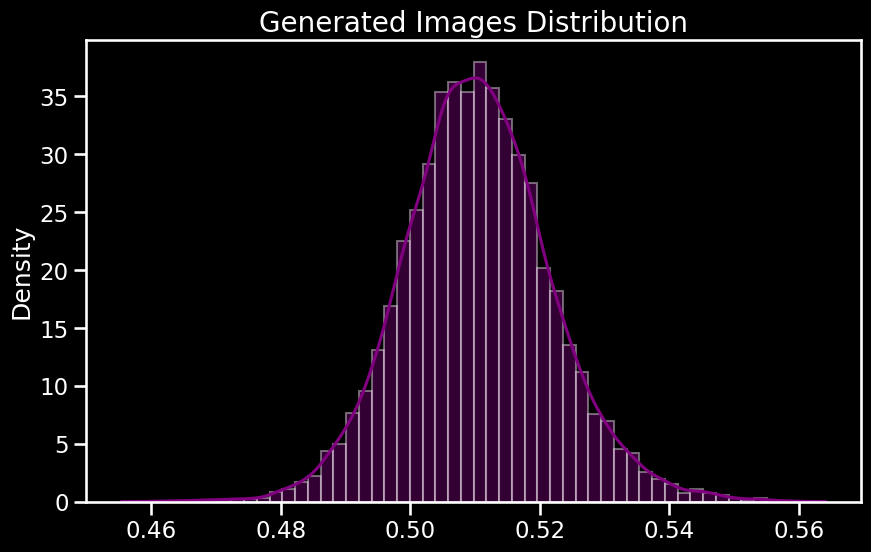

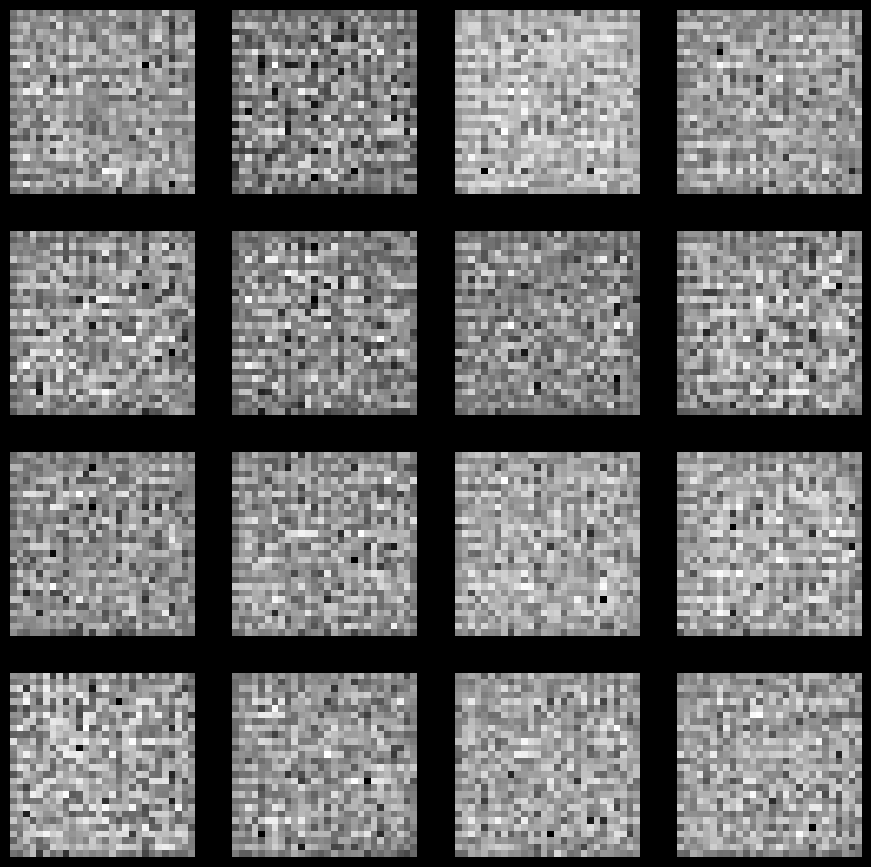

4/4 [==============================] - 0s 3ms/step
20 [D loss: 0.033768, accuracy: 100.00%] [G loss: 1.445385]
1/1 [==============================] - 0s 20ms/step


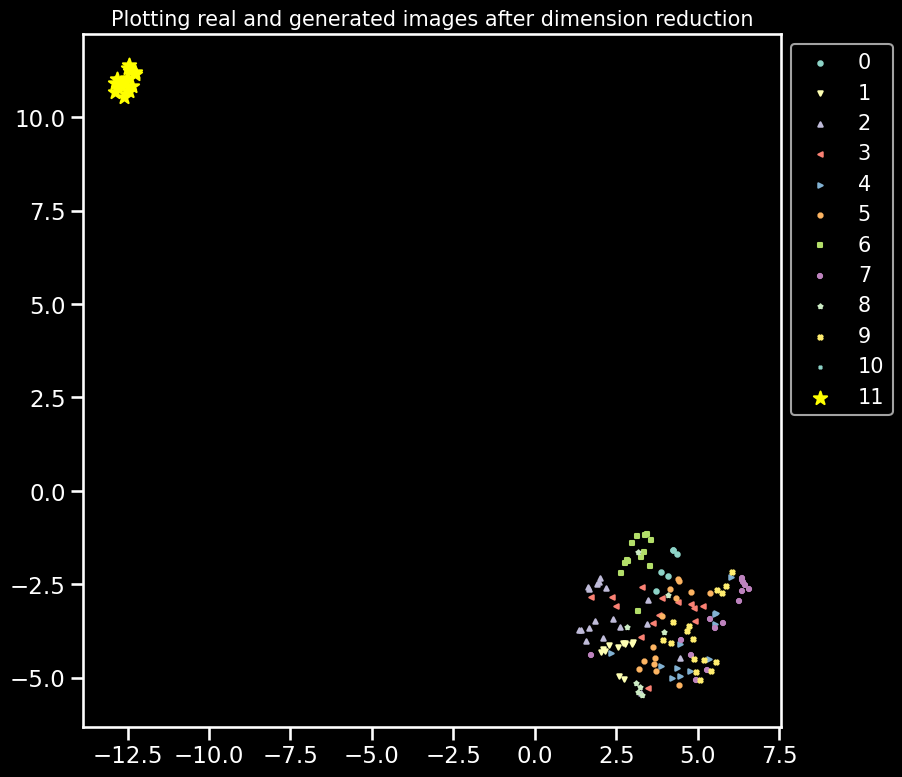

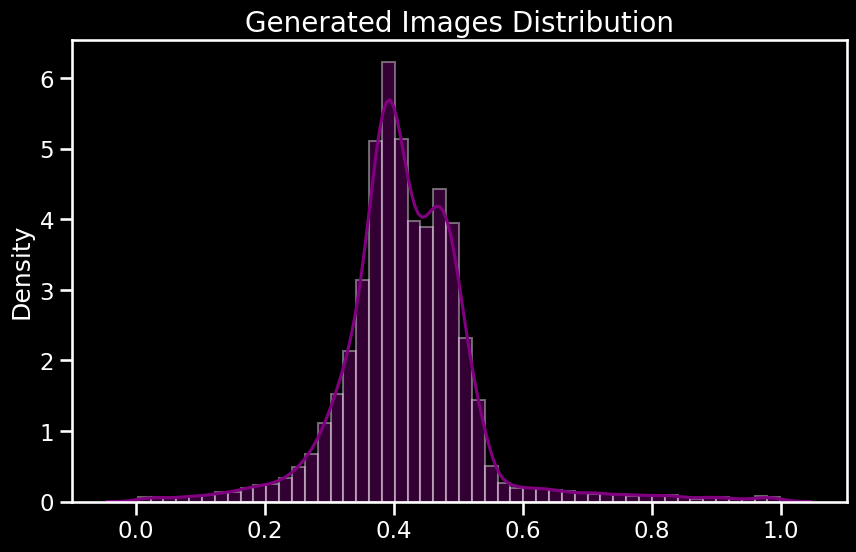

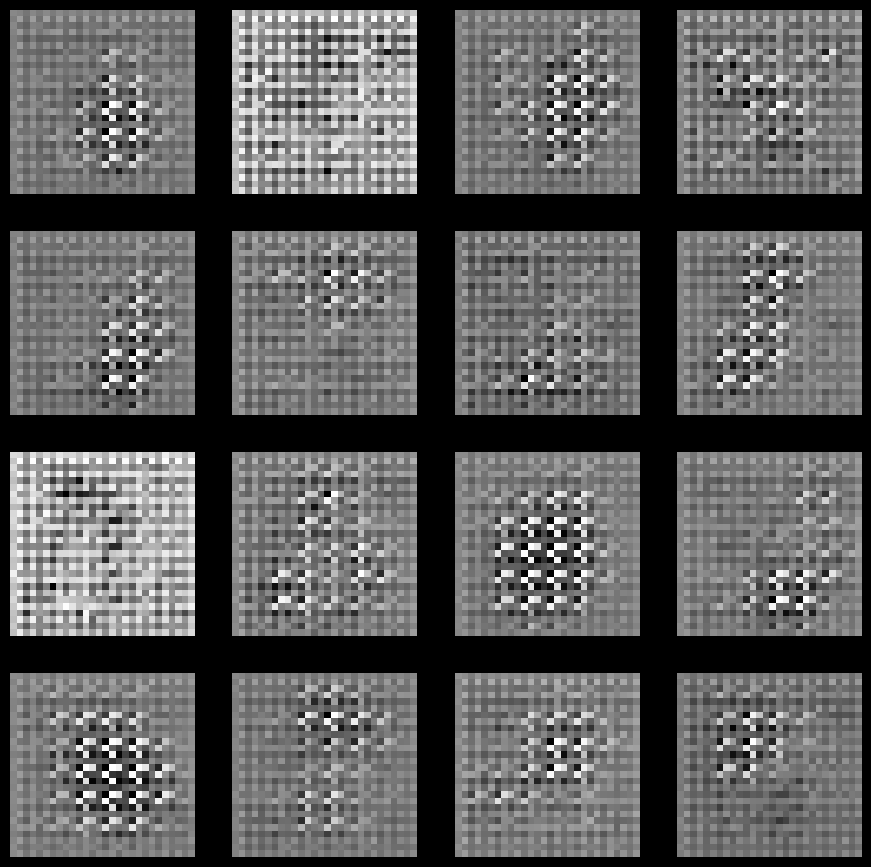

4/4 [==============================] - 0s 3ms/step
40 [D loss: 0.005502, accuracy: 100.00%] [G loss: 0.001090]
1/1 [==============================] - 0s 20ms/step


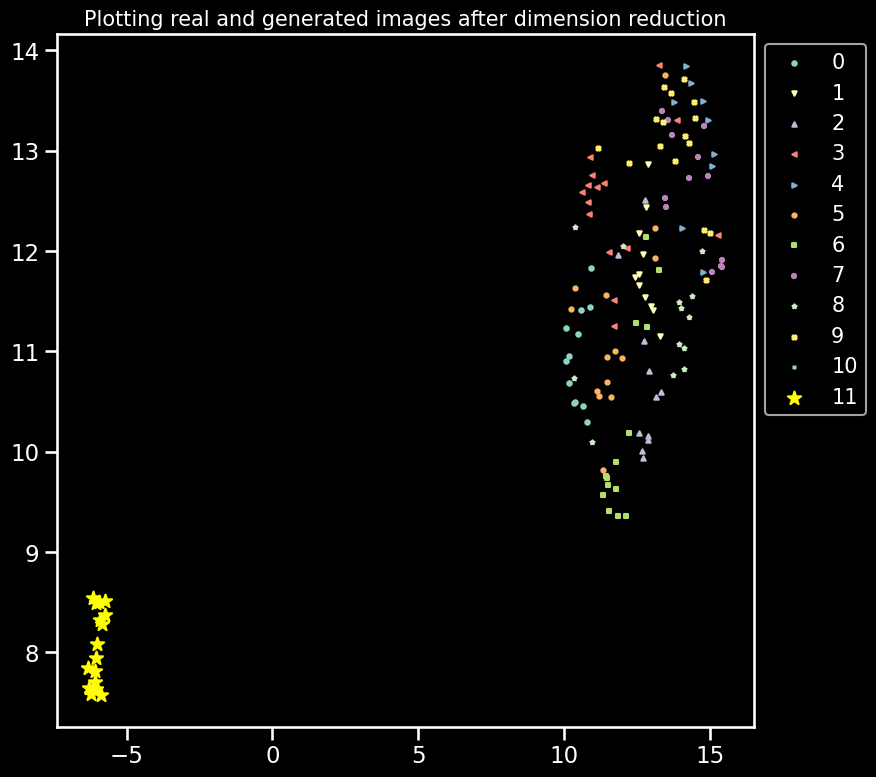

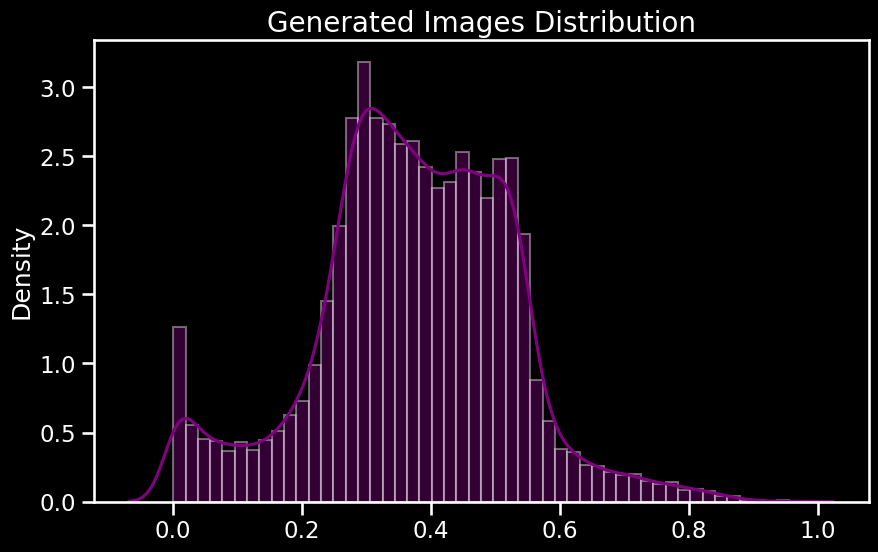

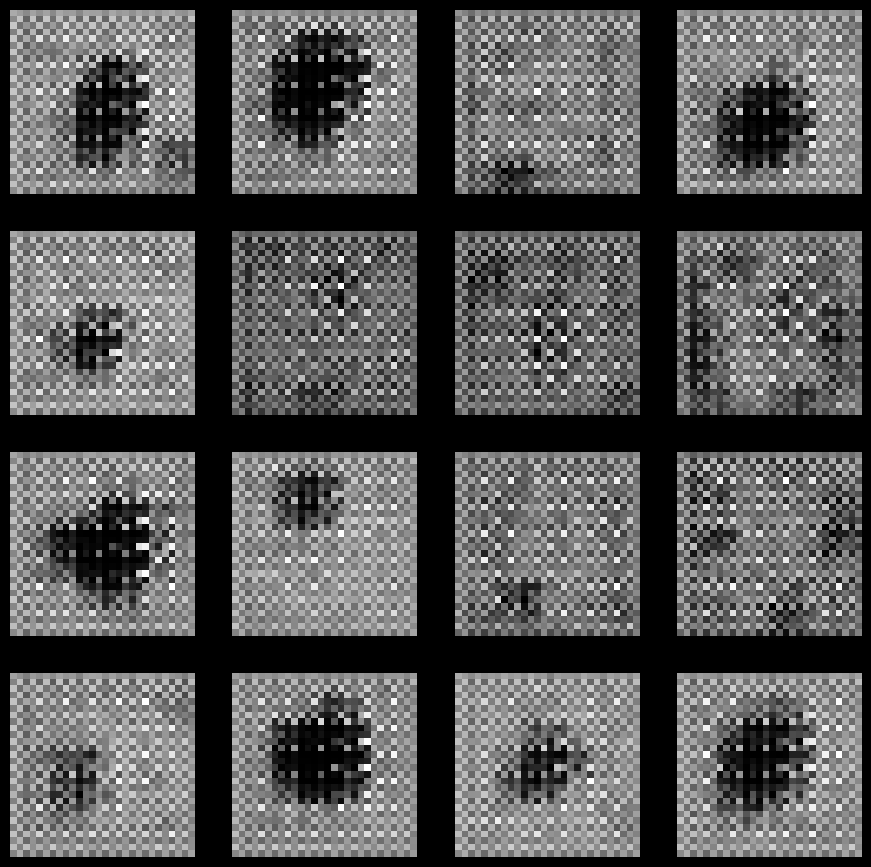

4/4 [==============================] - 0s 3ms/step
60 [D loss: 0.000492, accuracy: 100.00%] [G loss: 0.006188]
1/1 [==============================] - 0s 20ms/step


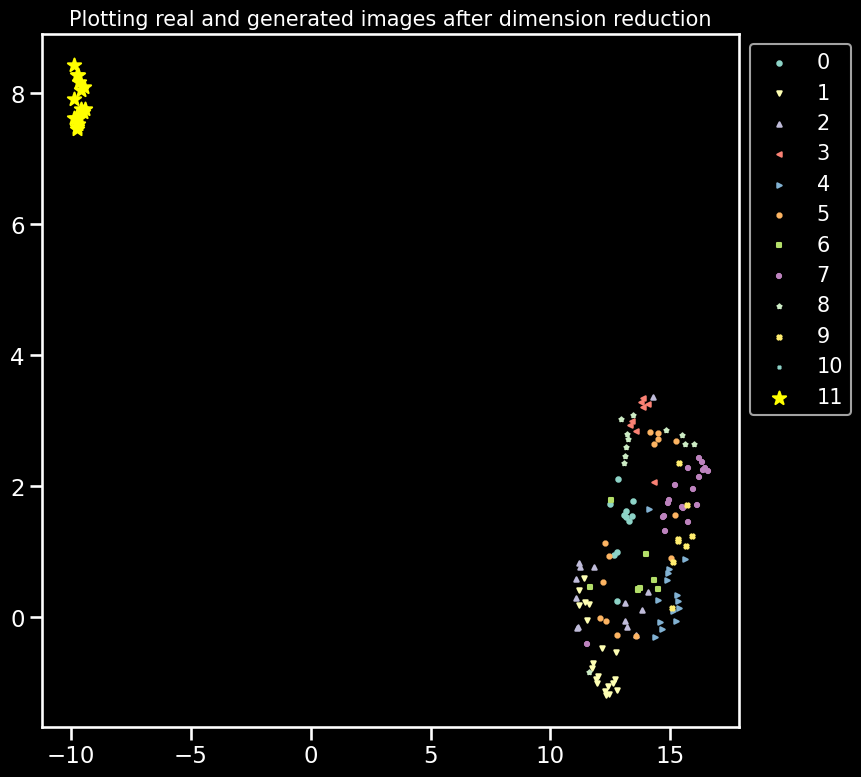

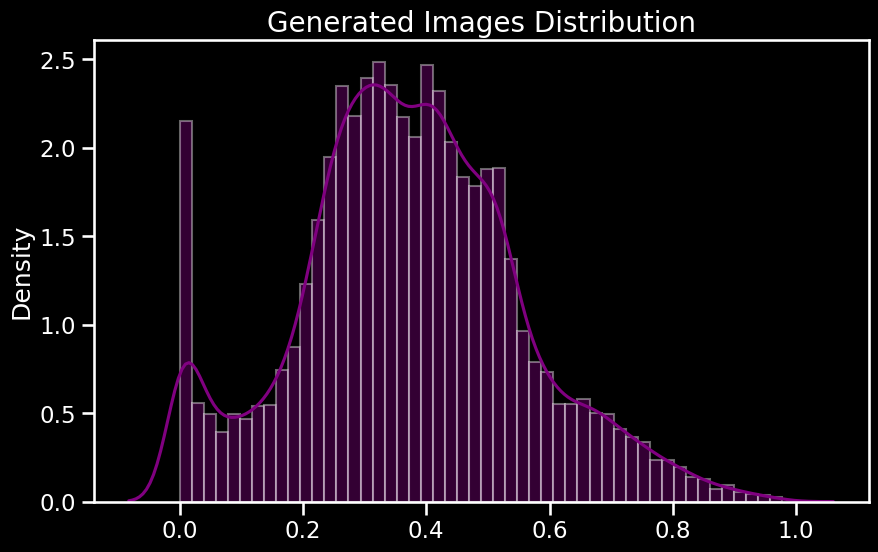

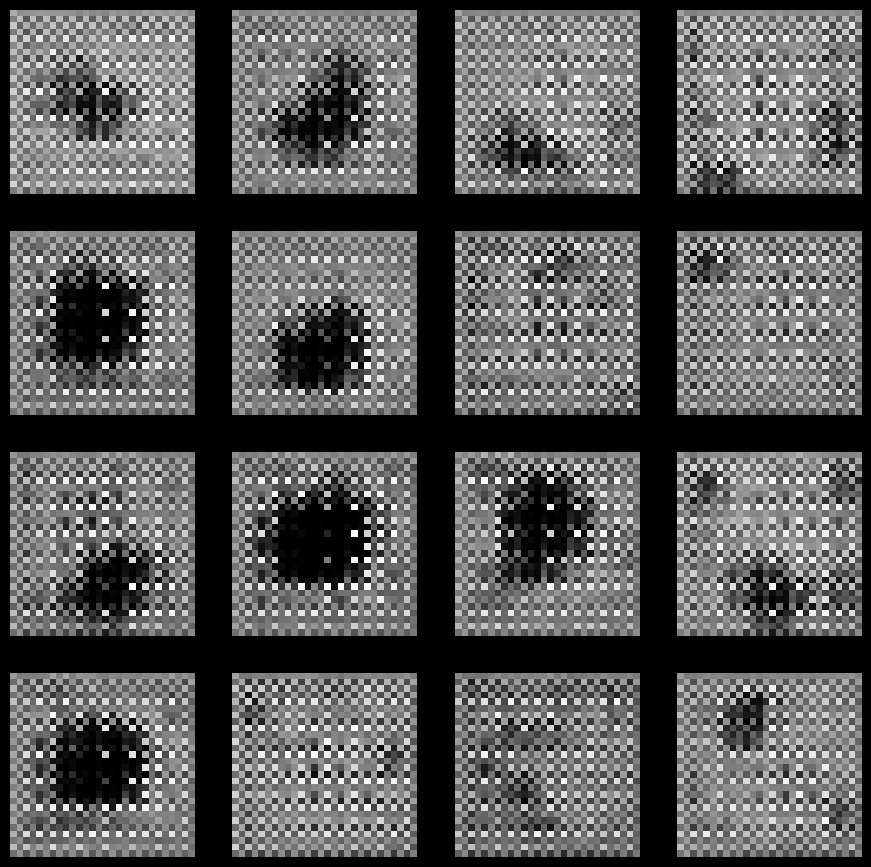

4/4 [==============================] - 0s 3ms/step
80 [D loss: 0.000169, accuracy: 100.00%] [G loss: 0.002594]
1/1 [==============================] - 0s 20ms/step


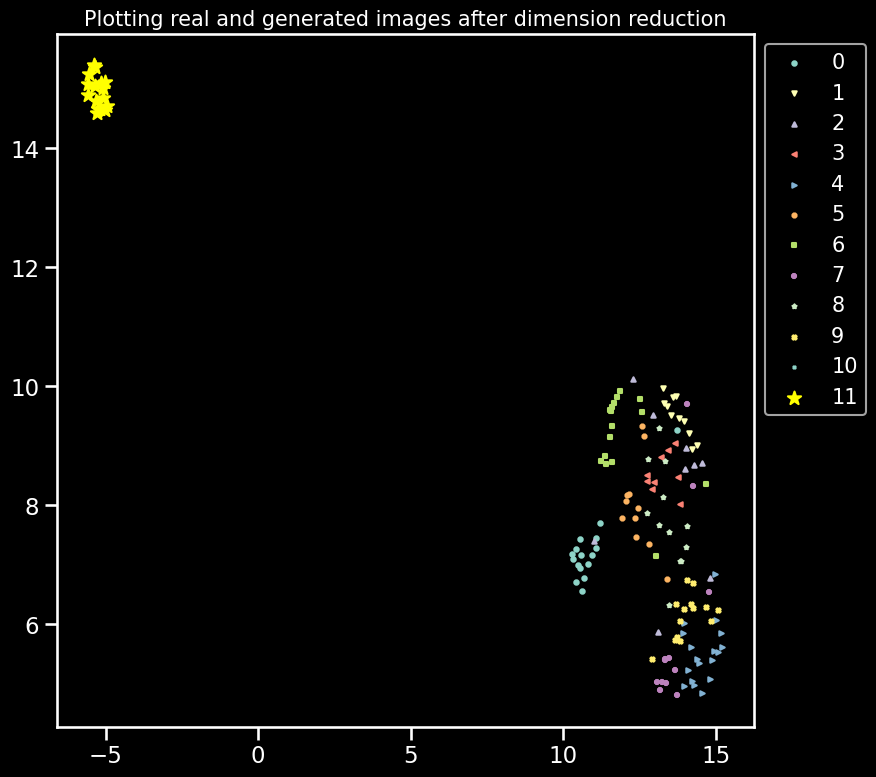

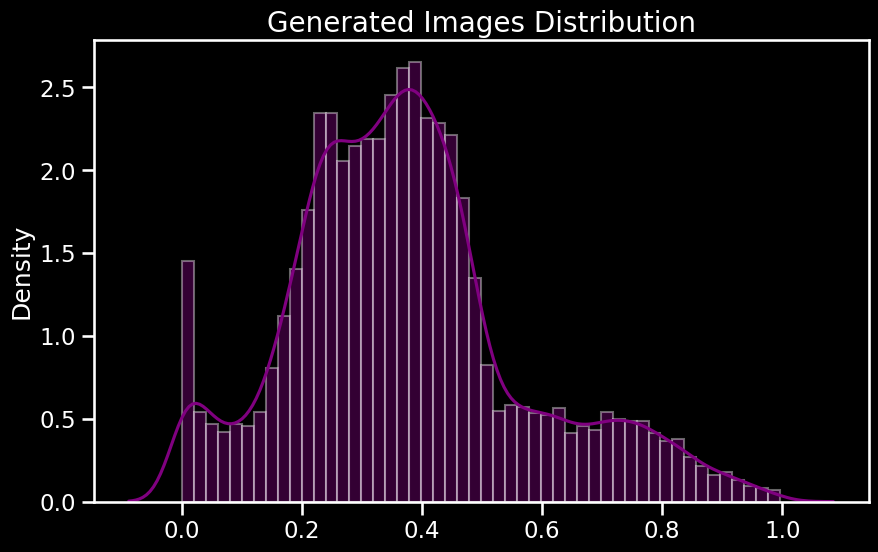

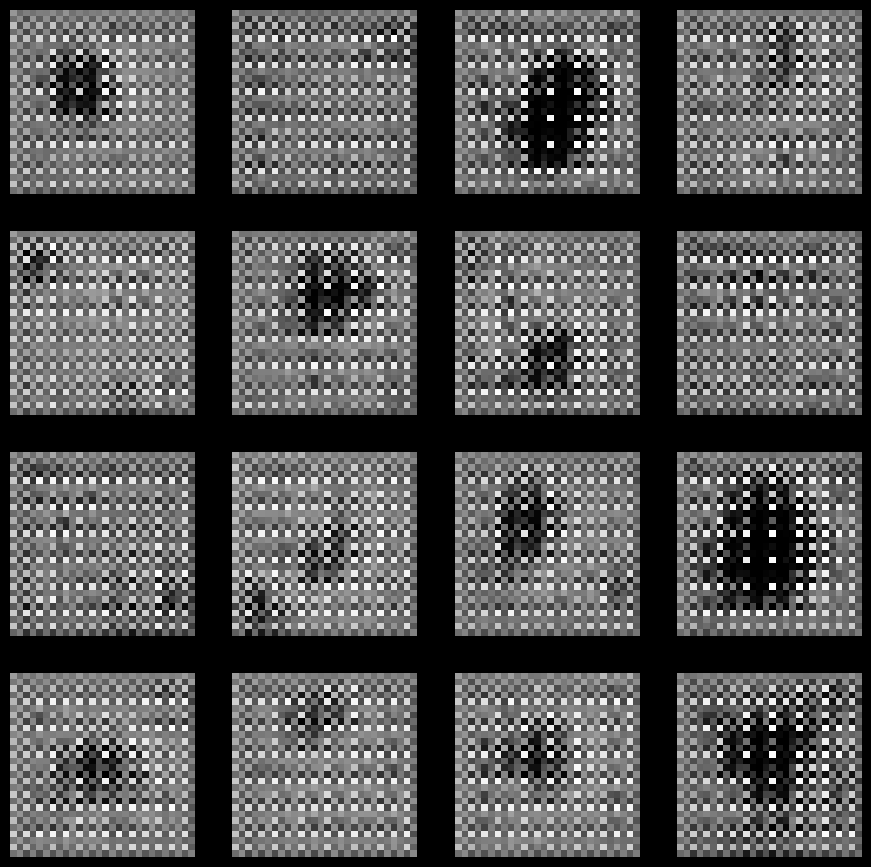

4/4 [==============================] - 0s 3ms/step
100 [D loss: 0.000057, accuracy: 100.00%] [G loss: 0.003544]
1/1 [==============================] - 0s 20ms/step


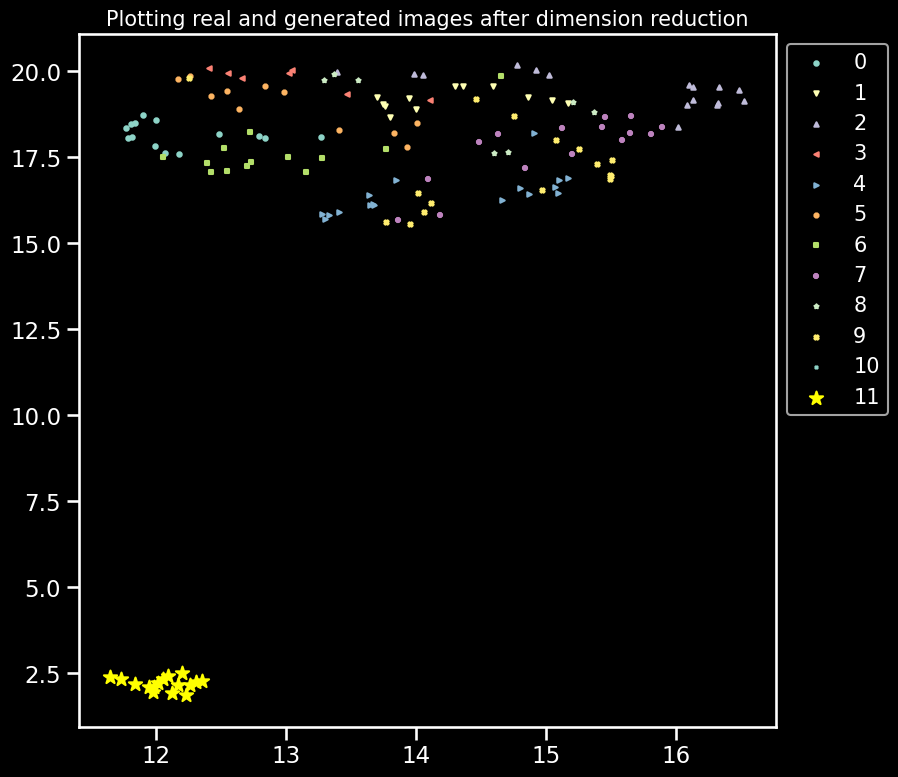

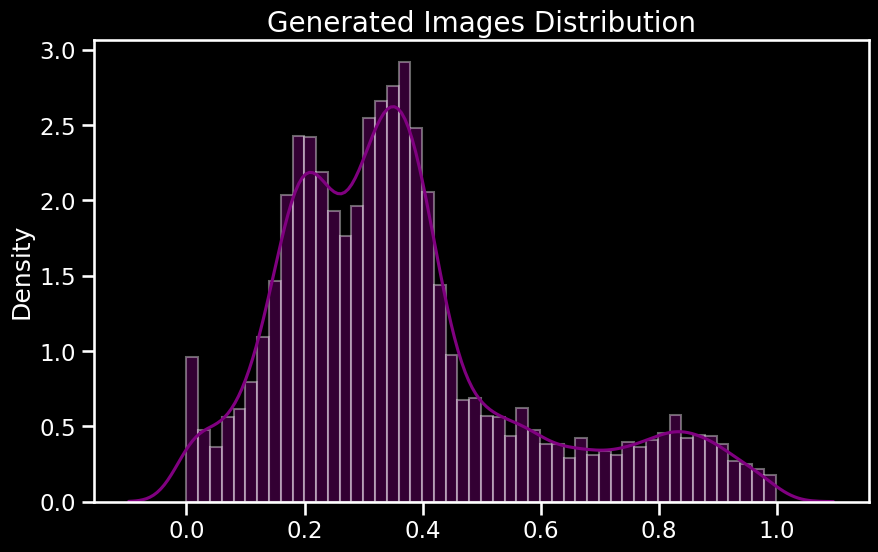

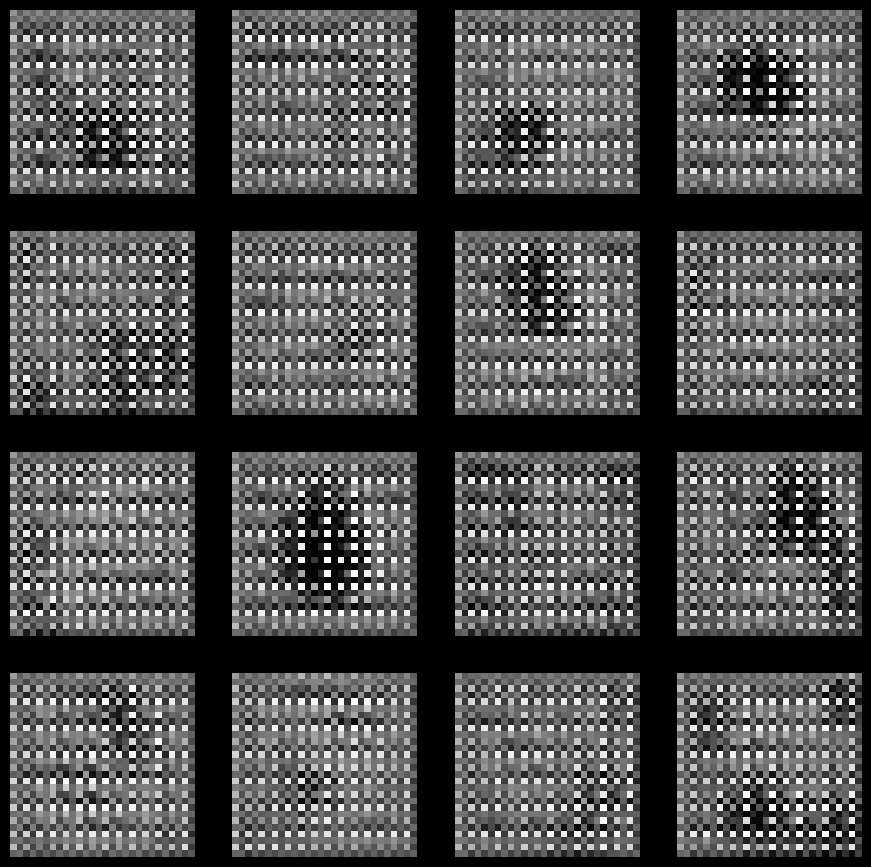

4/4 [==============================] - 0s 3ms/step
120 [D loss: 0.000074, accuracy: 100.00%] [G loss: 0.005034]
1/1 [==============================] - 0s 20ms/step


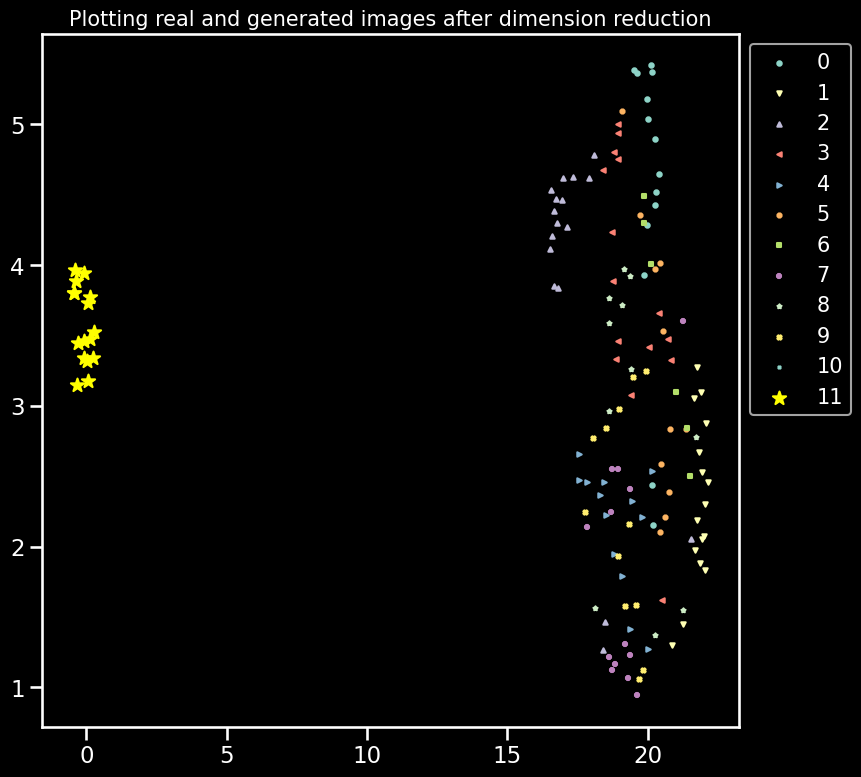

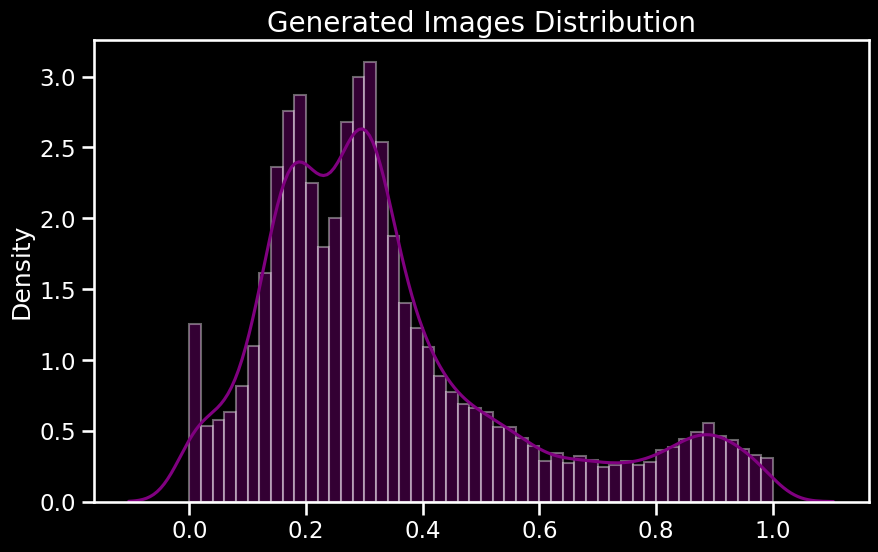

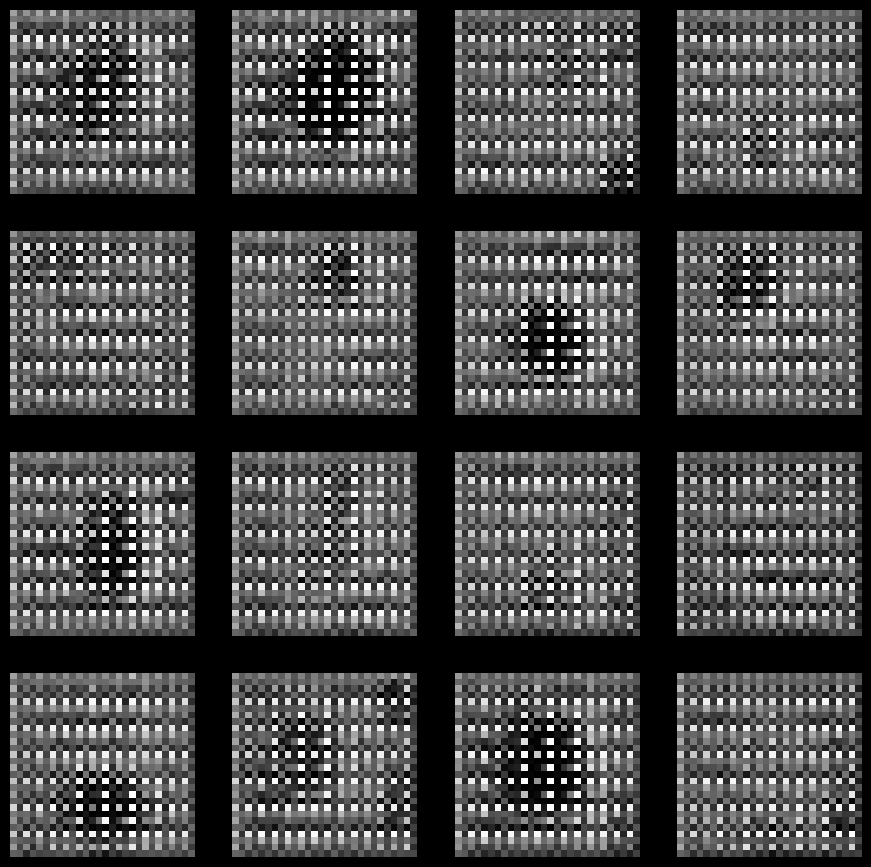

4/4 [==============================] - 0s 3ms/step
140 [D loss: 0.000169, accuracy: 100.00%] [G loss: 0.070423]
1/1 [==============================] - 0s 20ms/step


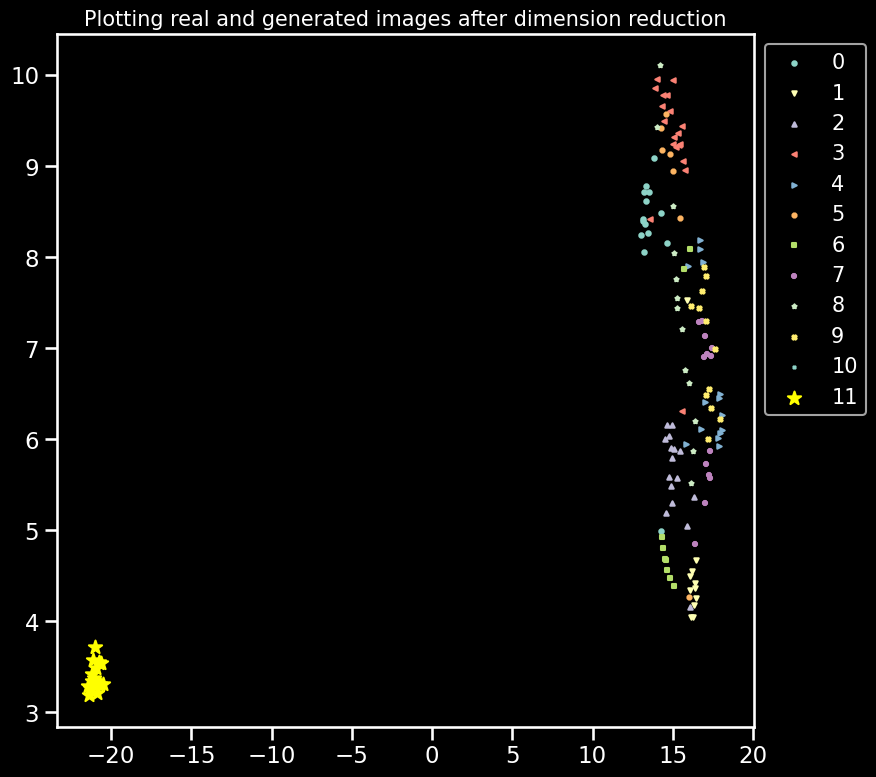

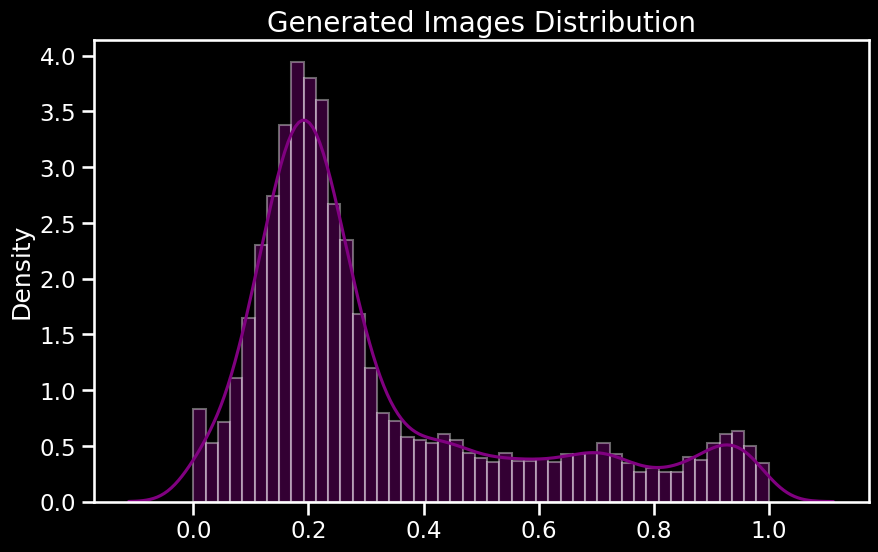

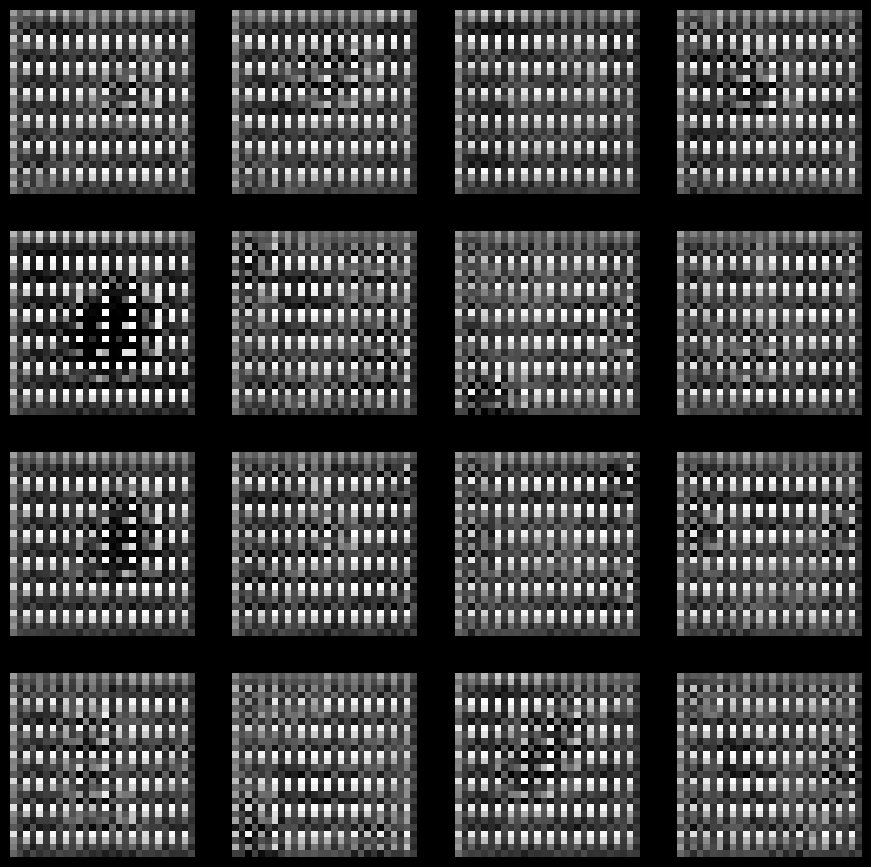

4/4 [==============================] - 0s 3ms/step
160 [D loss: 16.340620, accuracy: 50.00%] [G loss: 12.612963]
1/1 [==============================] - 0s 21ms/step


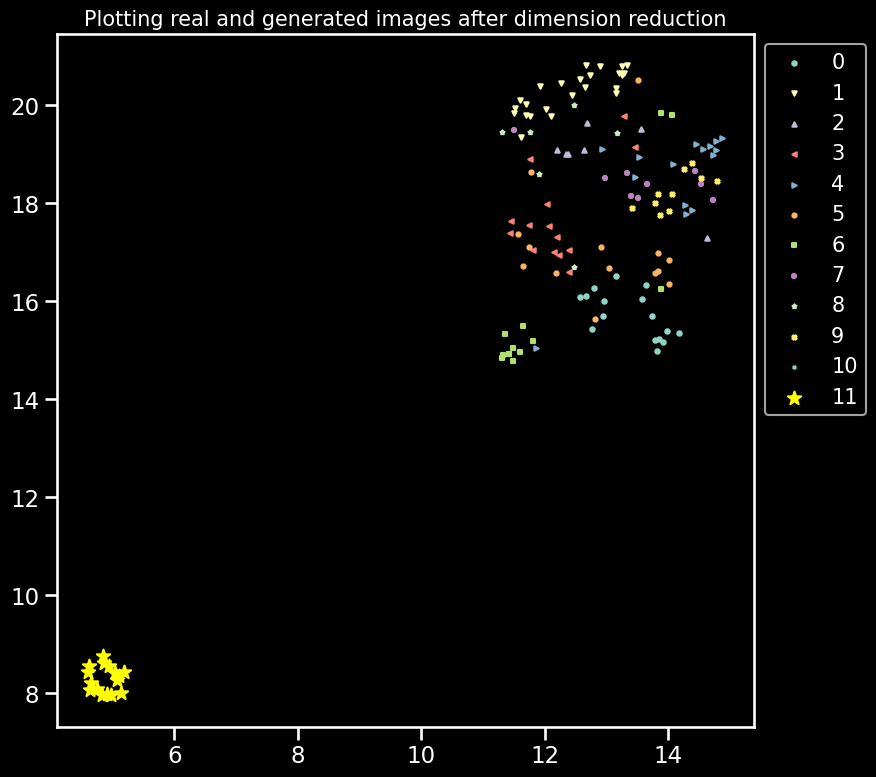

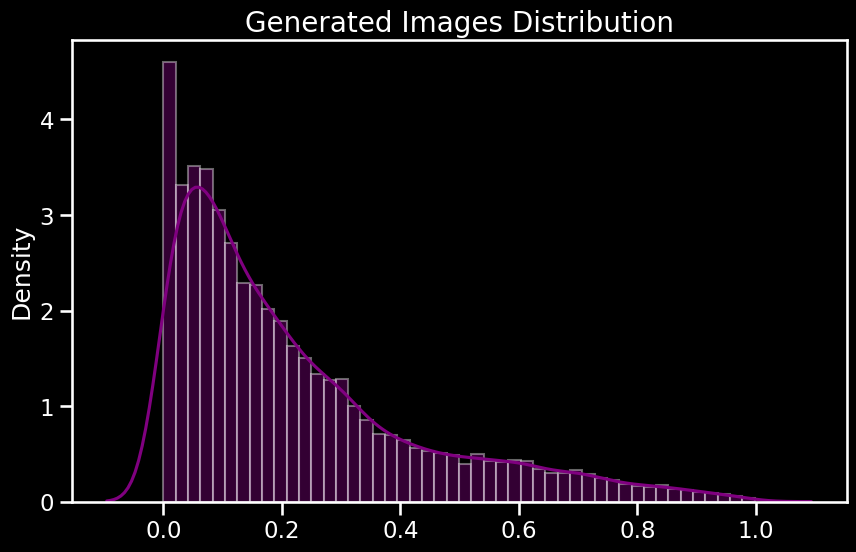

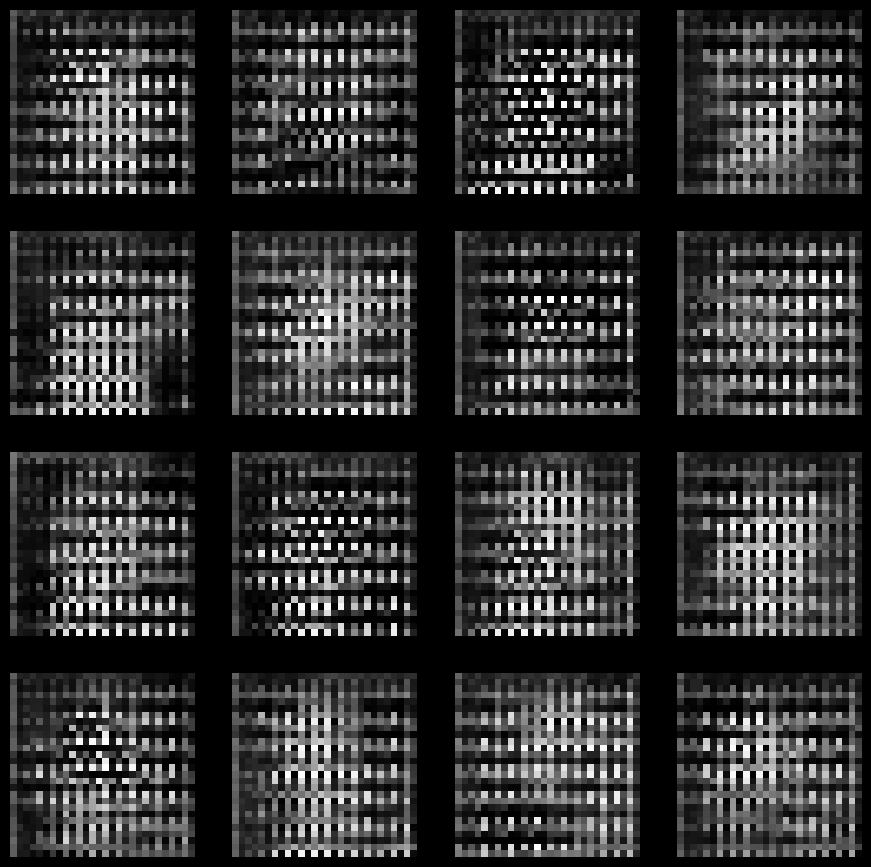

4/4 [==============================] - 0s 3ms/step
180 [D loss: 0.038572, accuracy: 99.22%] [G loss: 4.652996]
1/1 [==============================] - 0s 21ms/step


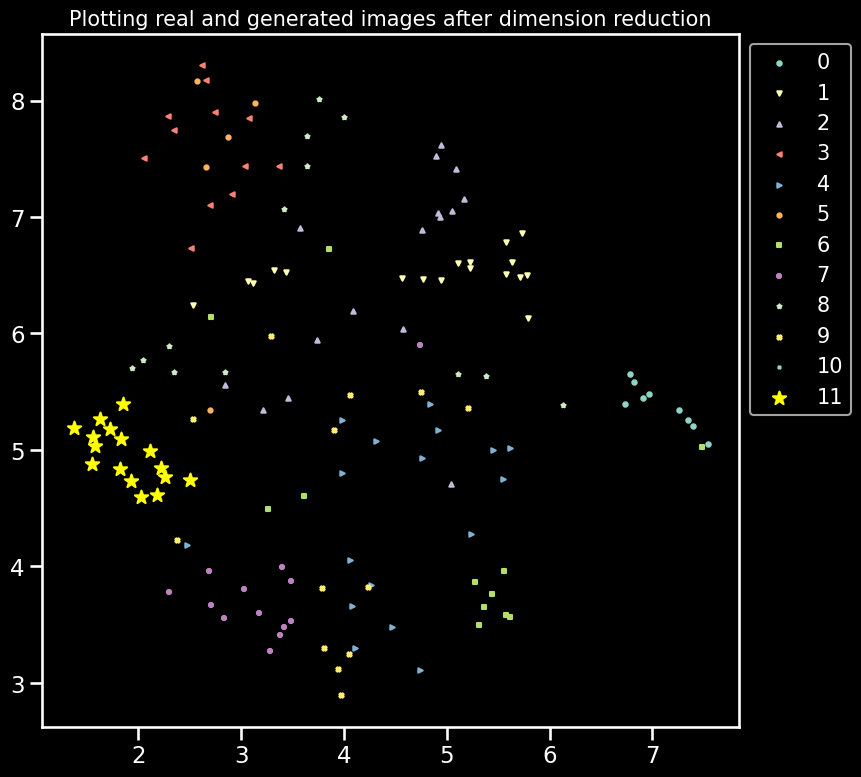

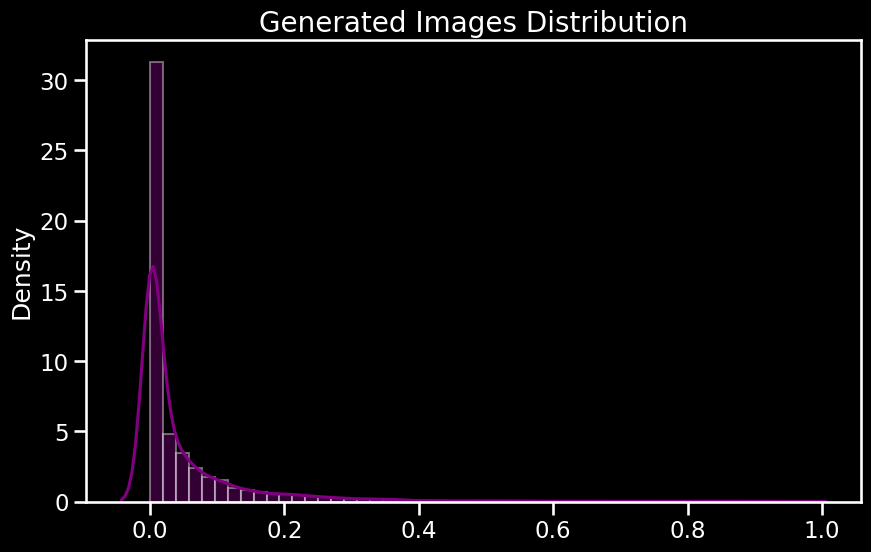

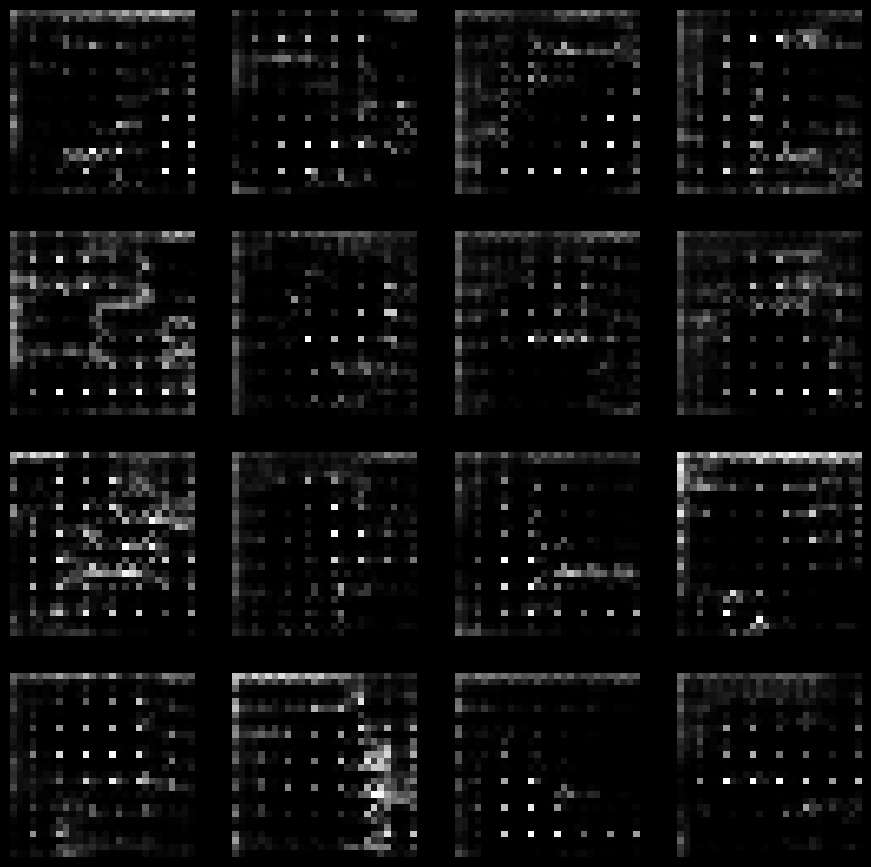

4/4 [==============================] - 0s 3ms/step
200 [D loss: 0.009390, accuracy: 100.00%] [G loss: 4.455971]
1/1 [==============================] - 0s 19ms/step


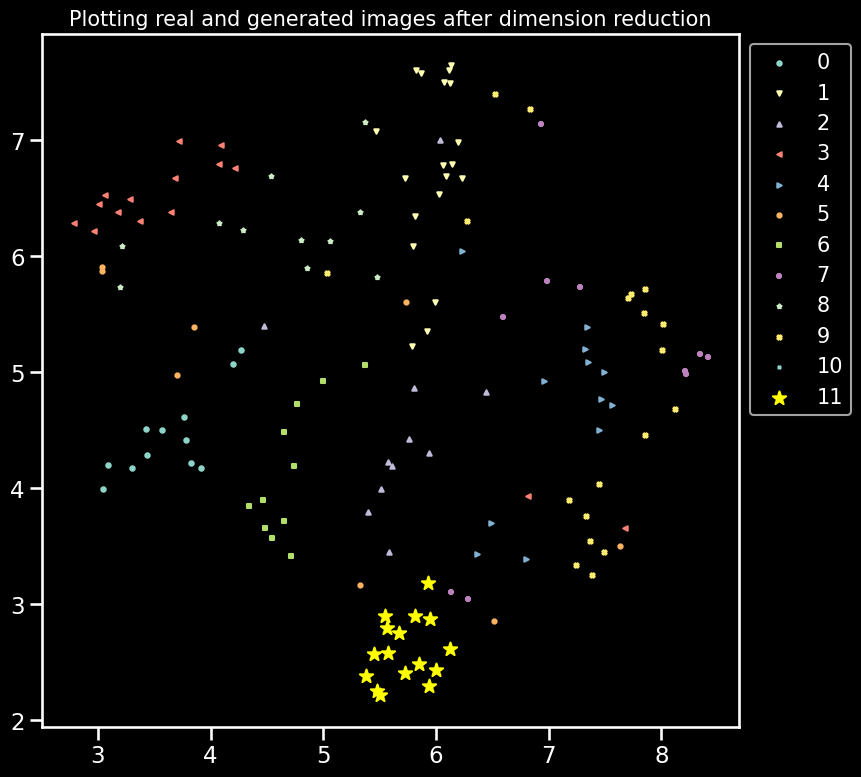

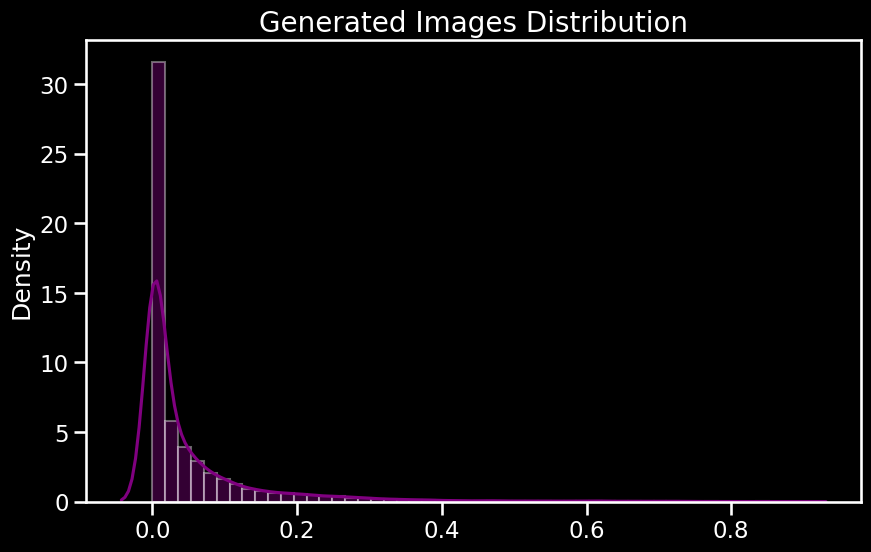

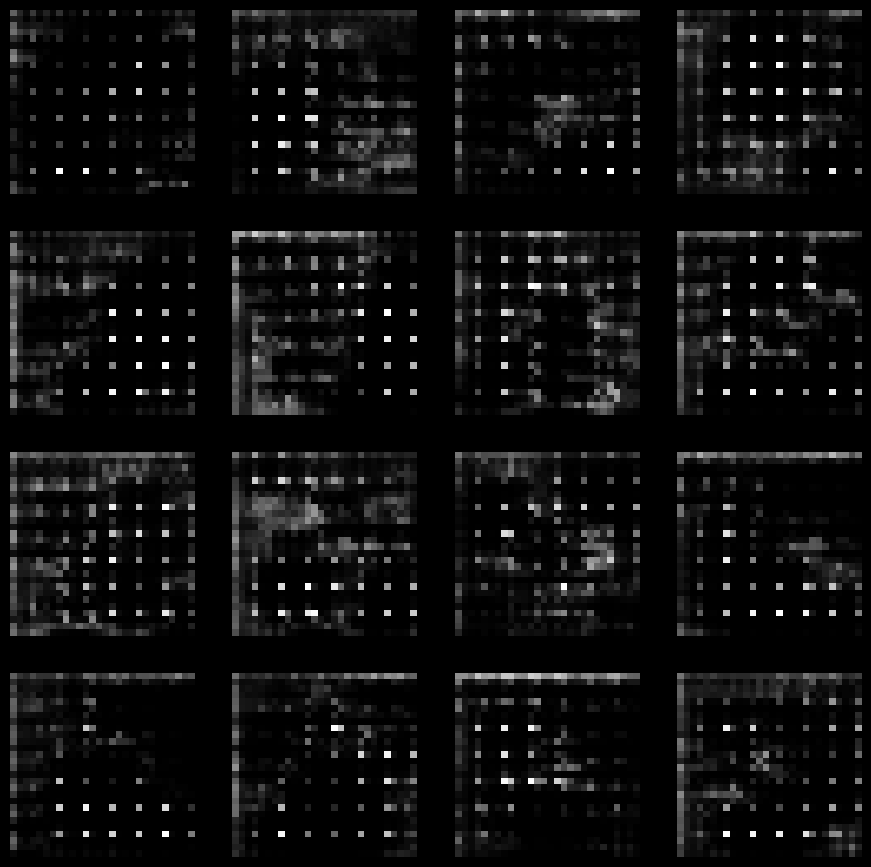

4/4 [==============================] - 0s 3ms/step
400 [D loss: 0.138539, accuracy: 93.75%] [G loss: 0.655145]
1/1 [==============================] - 0s 21ms/step


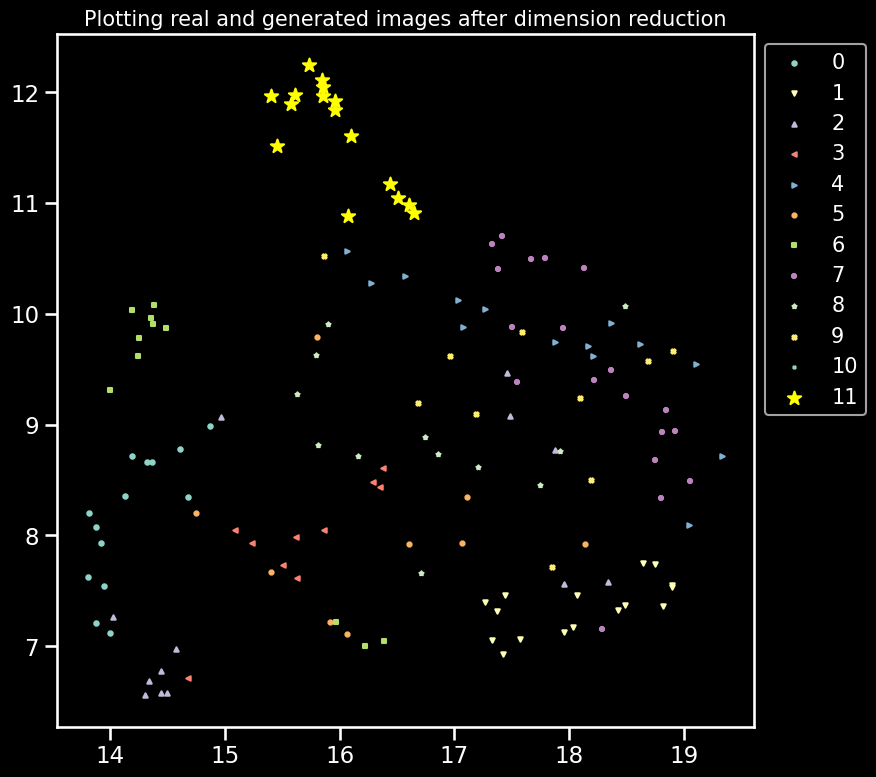

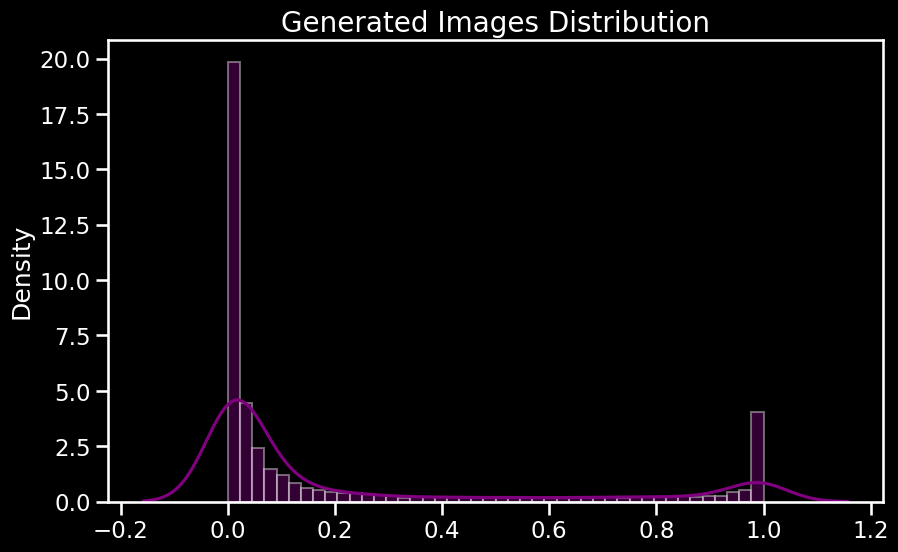

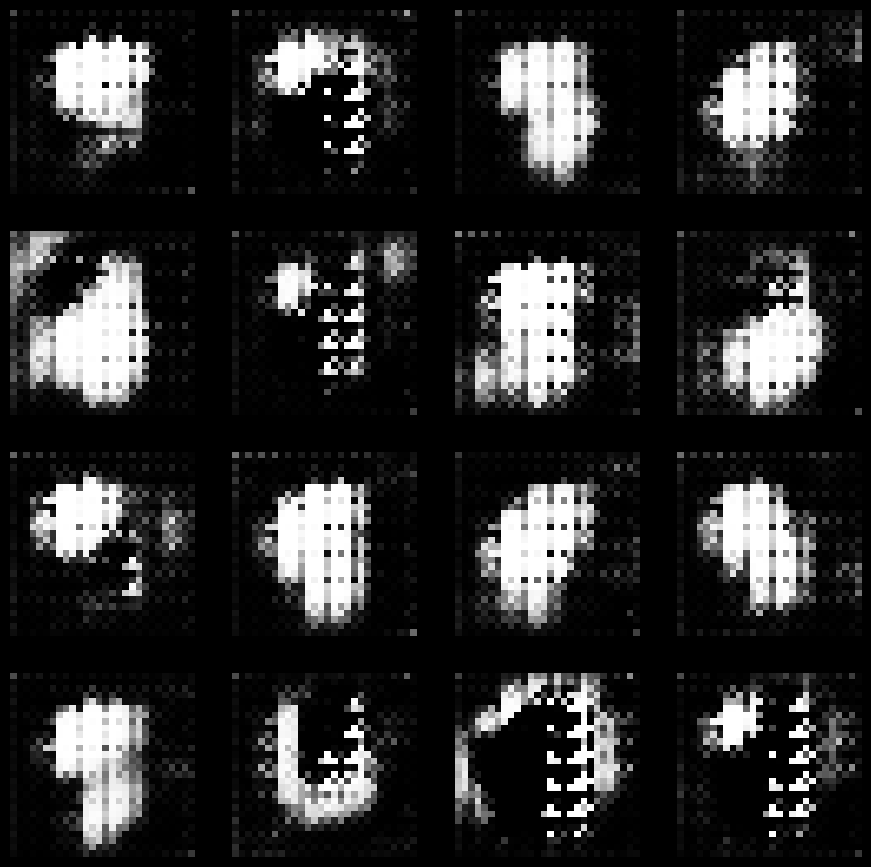

4/4 [==============================] - 0s 3ms/step
800 [D loss: 0.483288, accuracy: 77.73%] [G loss: 1.569465]
1/1 [==============================] - 0s 20ms/step


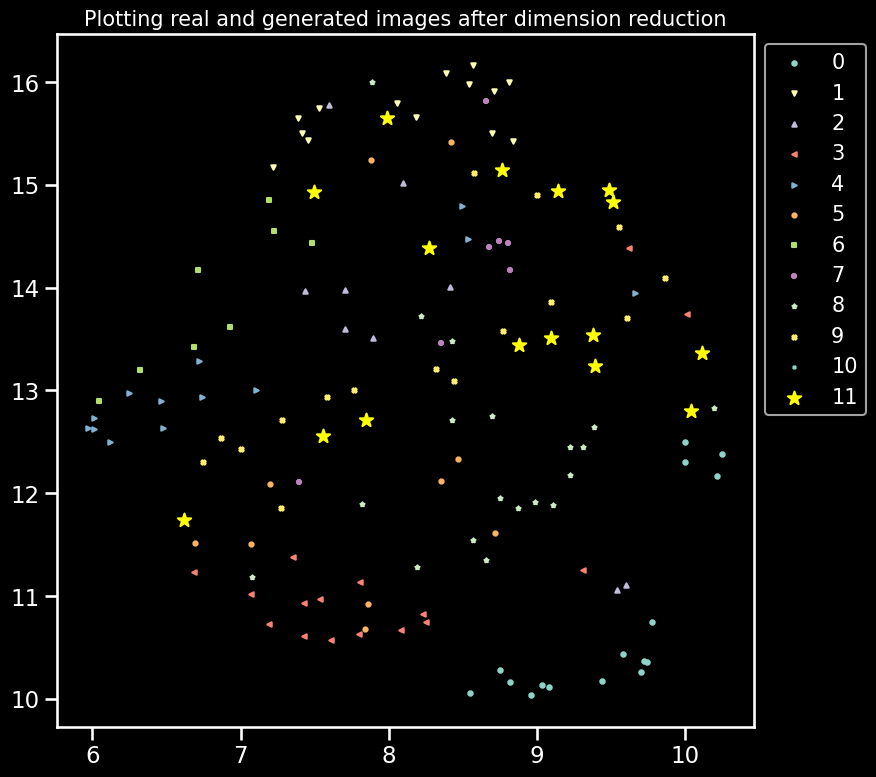

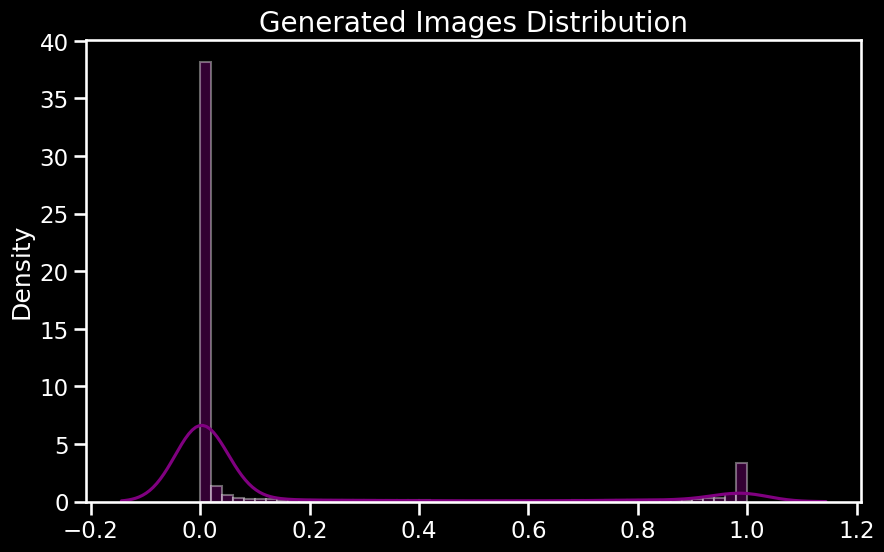

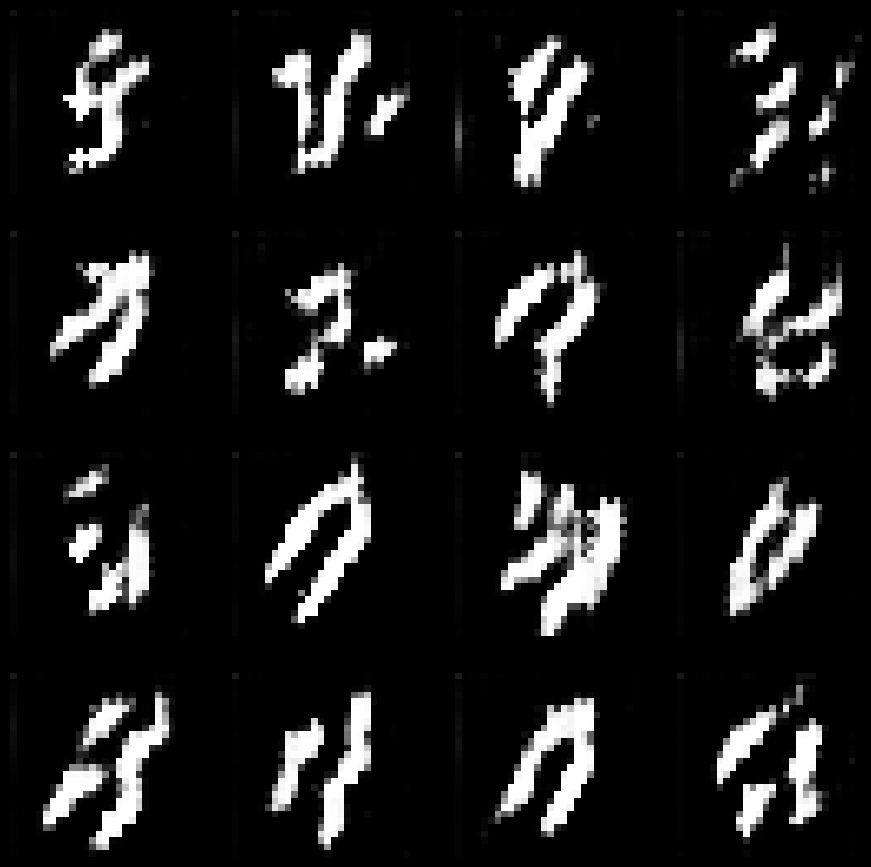

4/4 [==============================] - 0s 3ms/step
1200 [D loss: 0.427898, accuracy: 78.91%] [G loss: 1.883818]
1/1 [==============================] - 0s 19ms/step


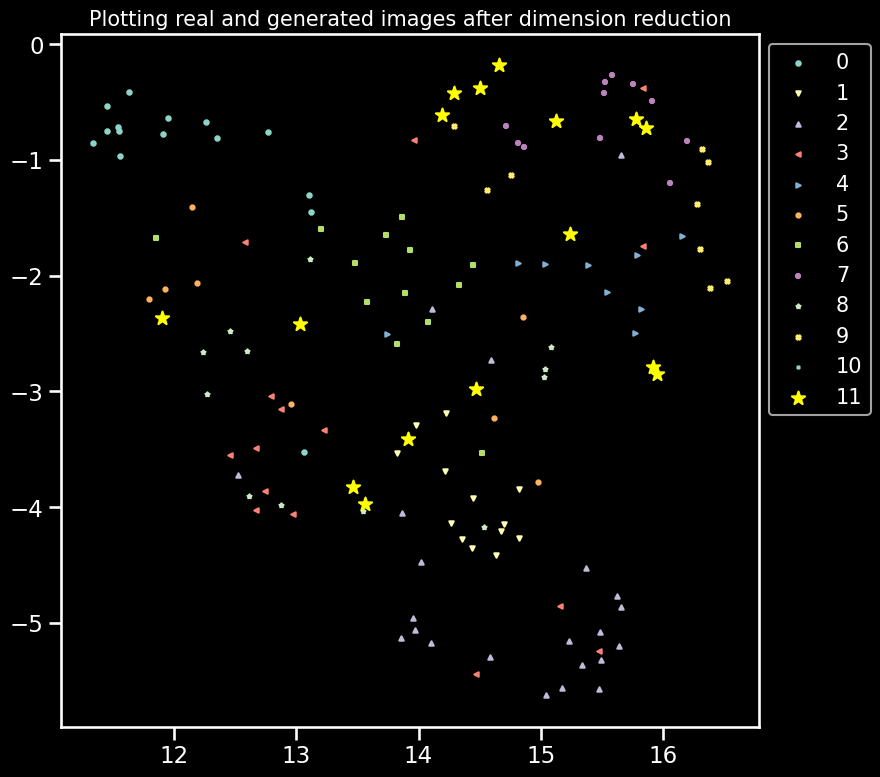

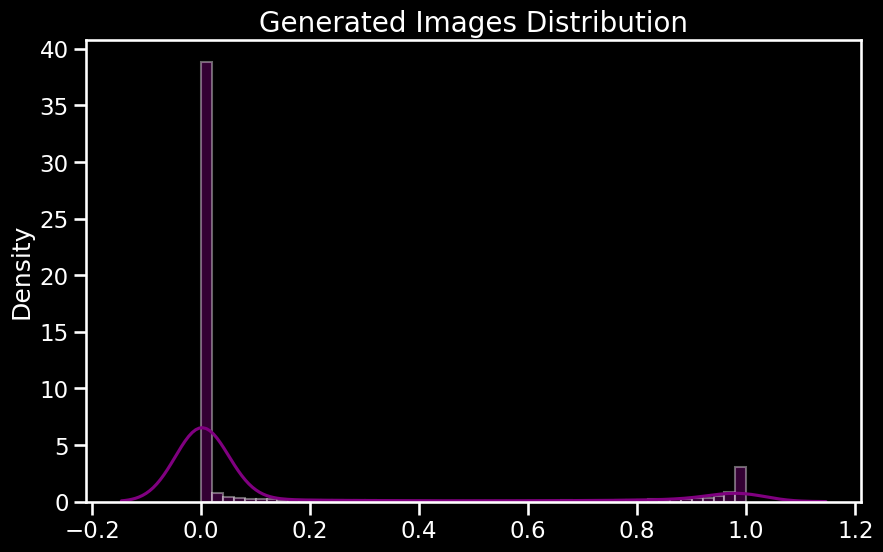

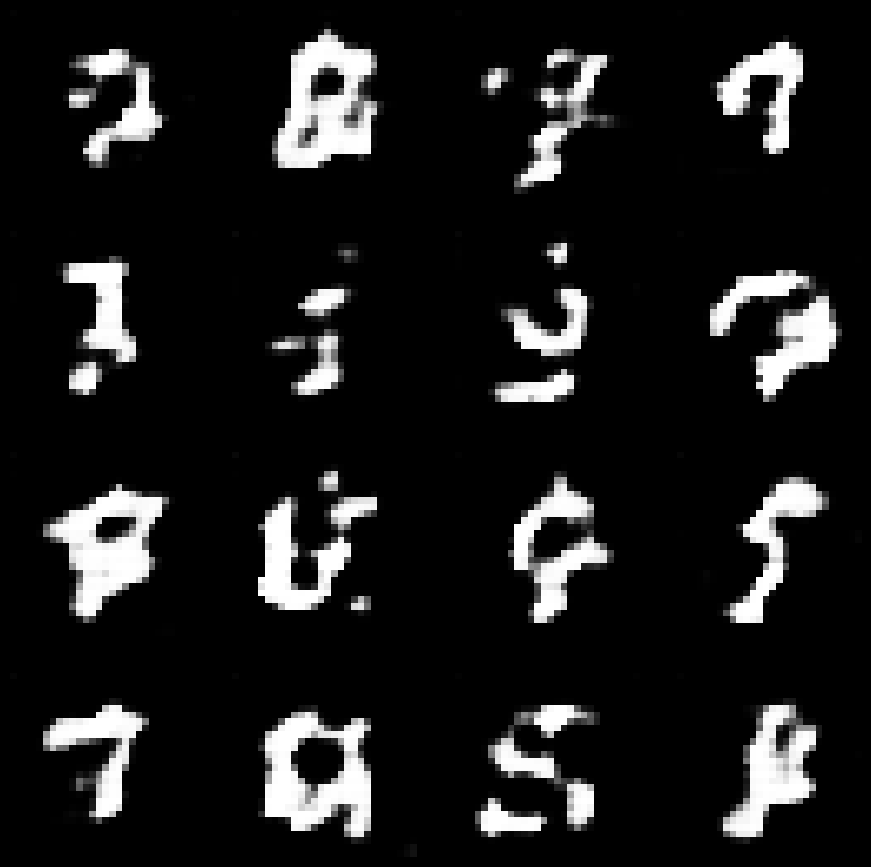

4/4 [==============================] - 0s 3ms/step
1600 [D loss: 0.415644, accuracy: 81.25%] [G loss: 1.791604]
1/1 [==============================] - 0s 25ms/step


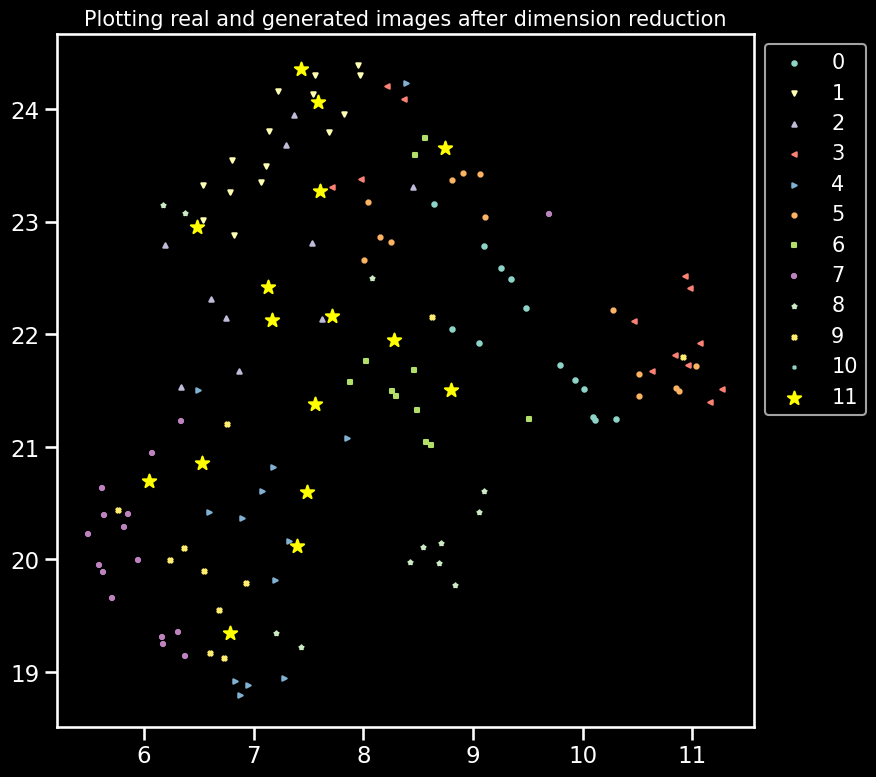

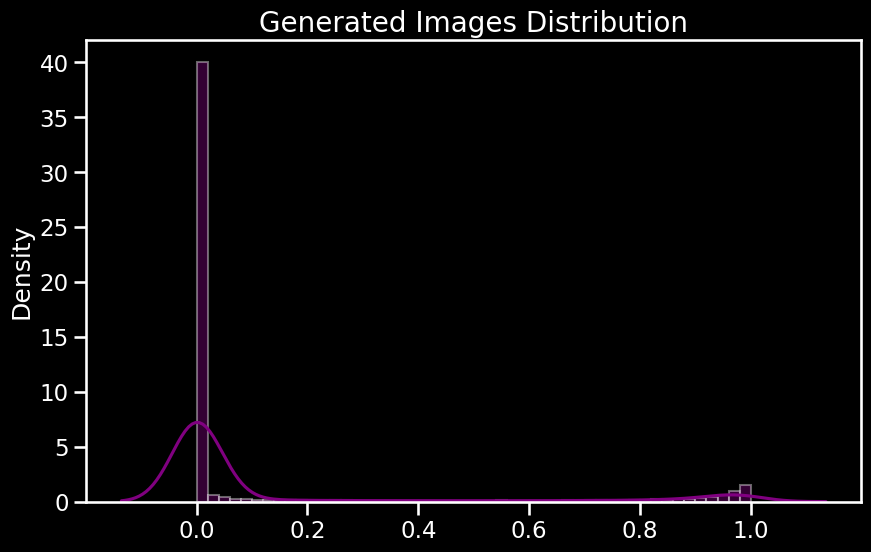

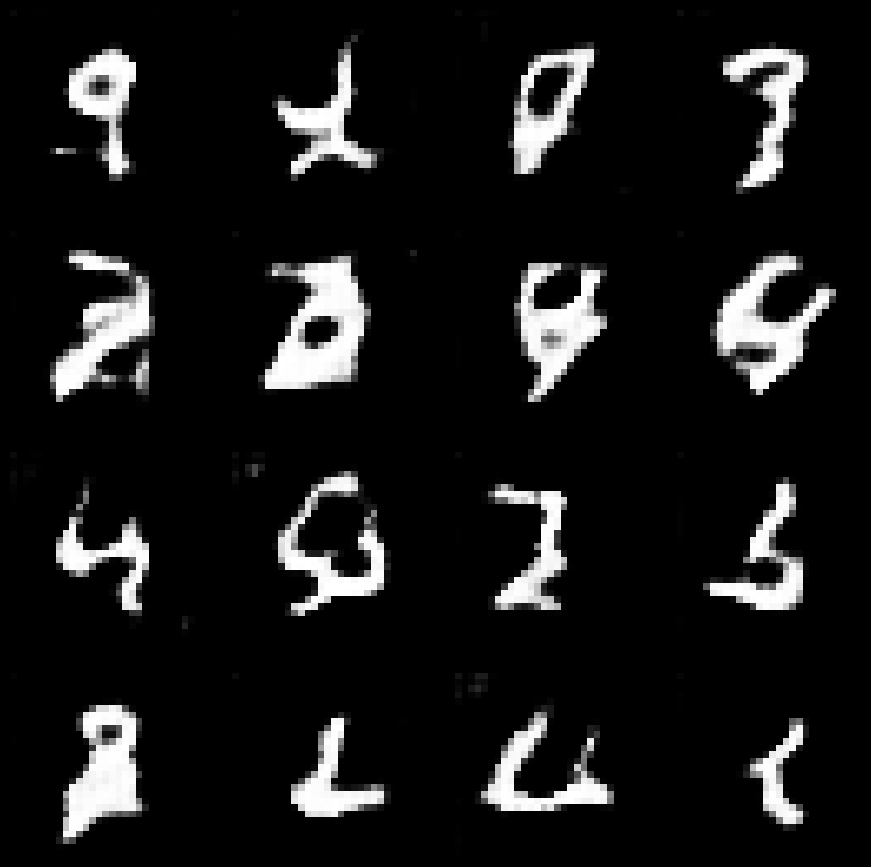

4/4 [==============================] - 0s 3ms/step
2000 [D loss: 0.401884, accuracy: 82.42%] [G loss: 1.772950]
1/1 [==============================] - 0s 19ms/step


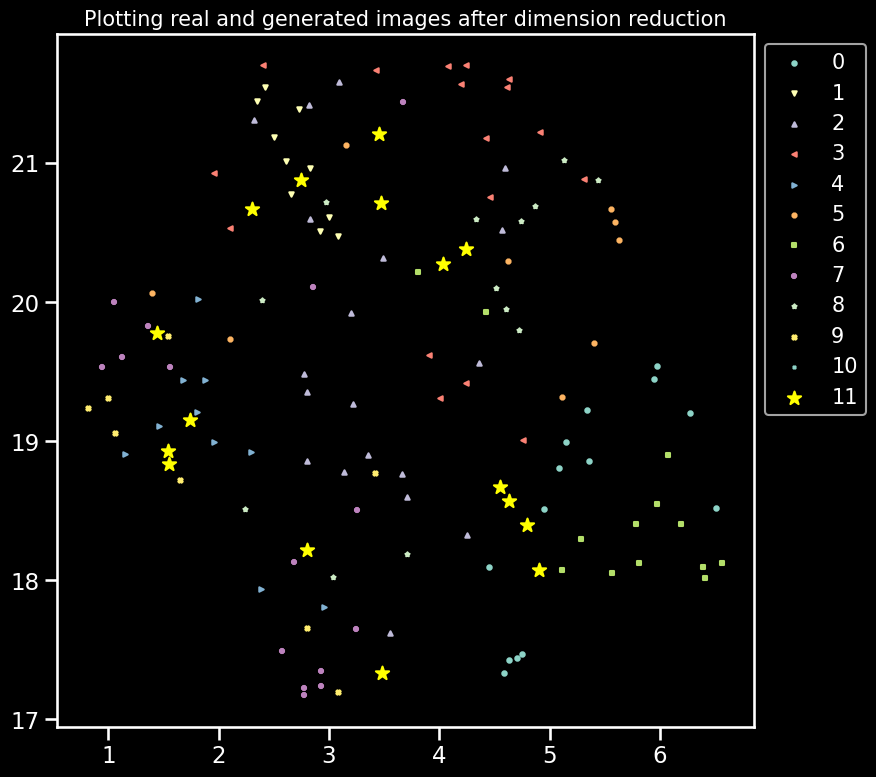

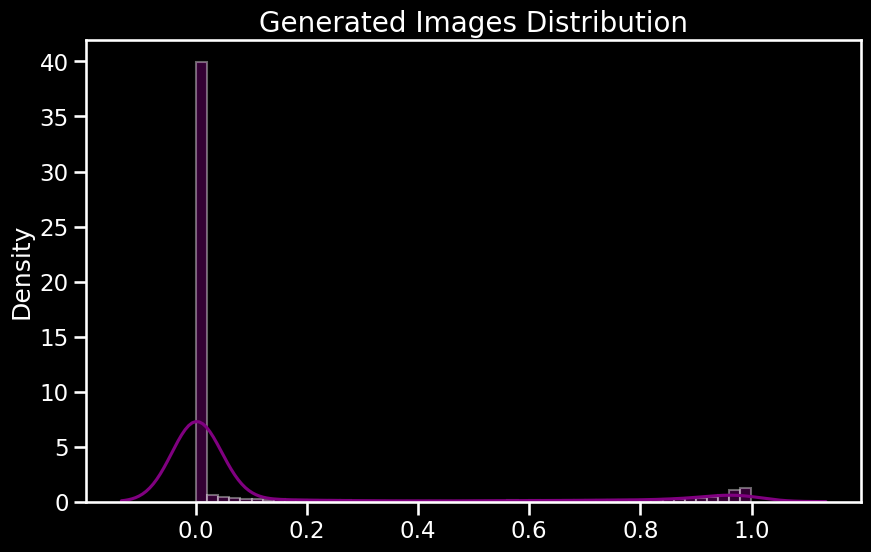

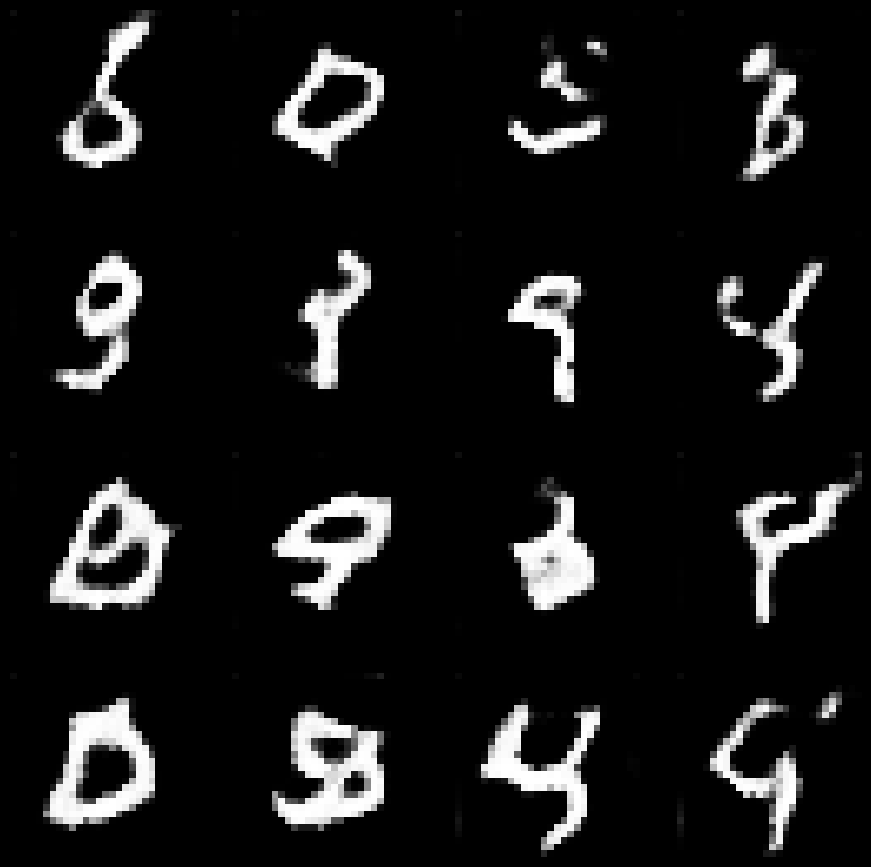

4/4 [==============================] - 0s 3ms/step
2400 [D loss: 0.537684, accuracy: 72.66%] [G loss: 1.603676]
1/1 [==============================] - 0s 20ms/step


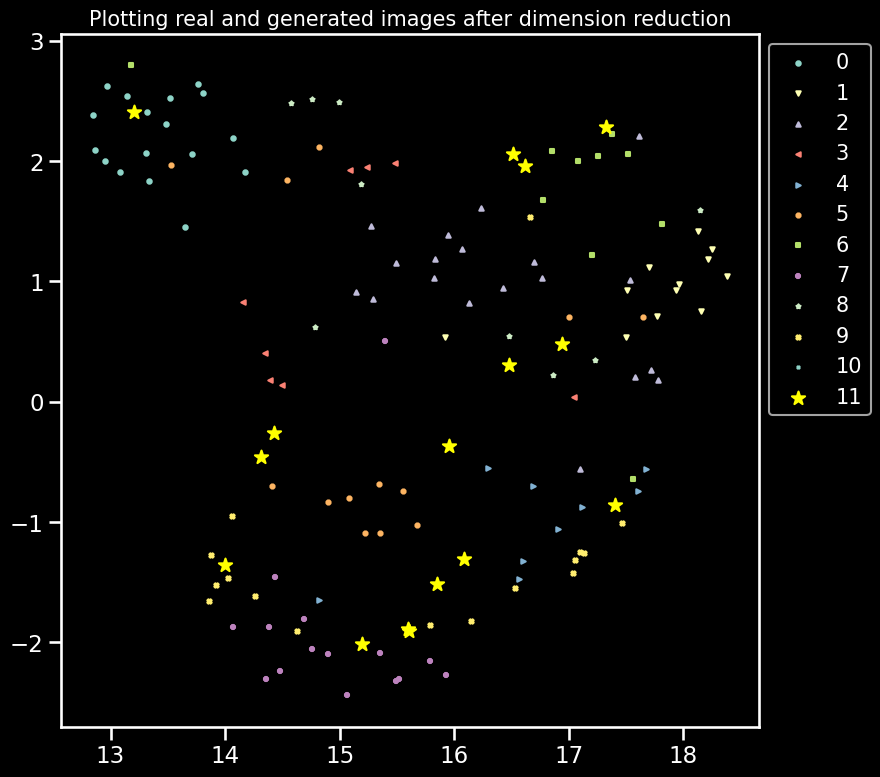

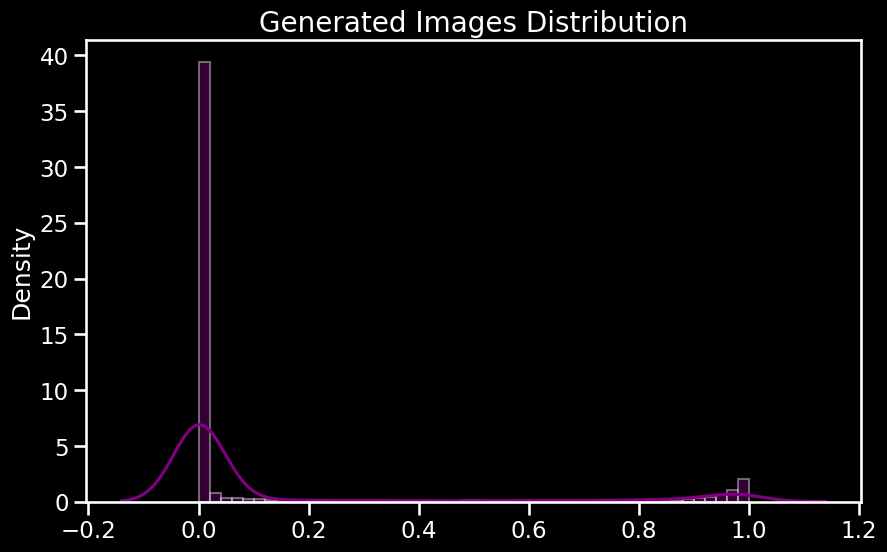

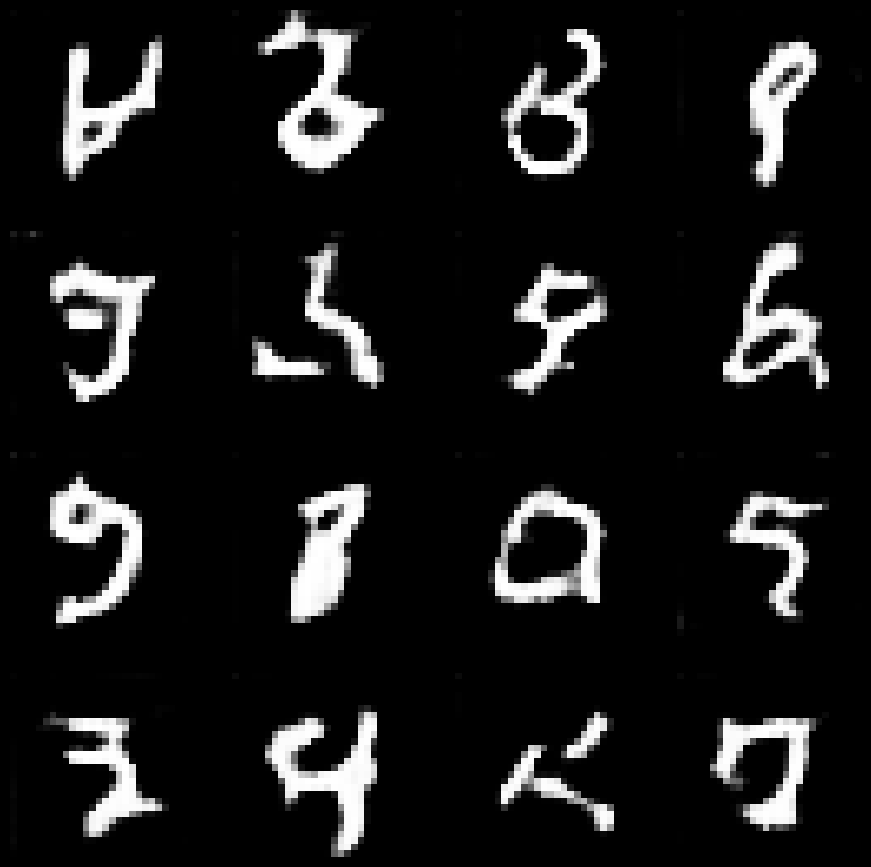

4/4 [==============================] - 0s 3ms/step
2800 [D loss: 0.376956, accuracy: 83.59%] [G loss: 2.040762]
1/1 [==============================] - 0s 19ms/step


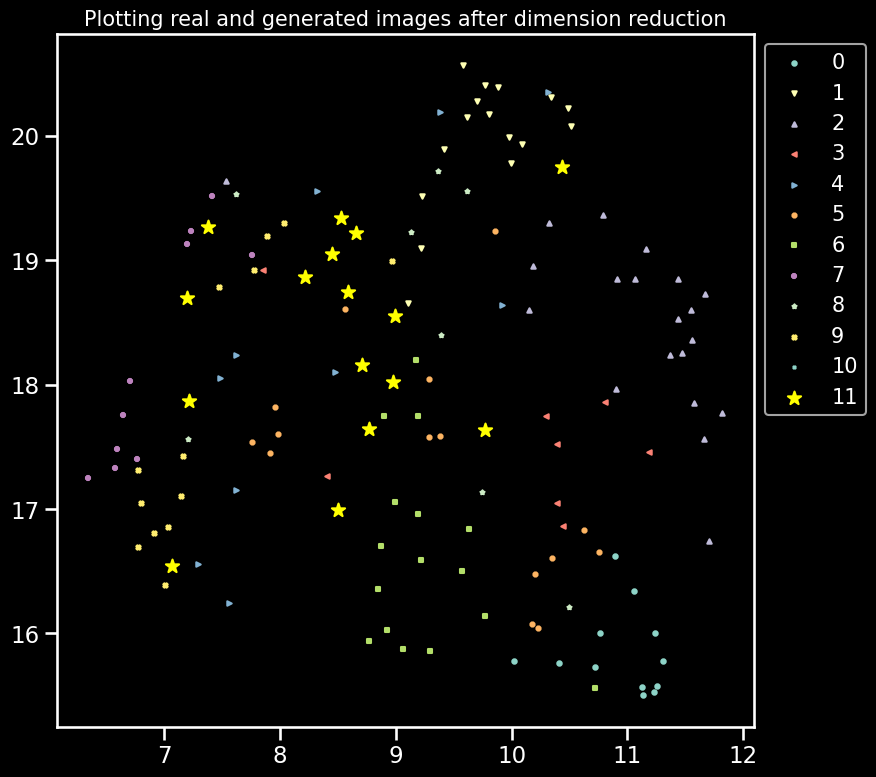

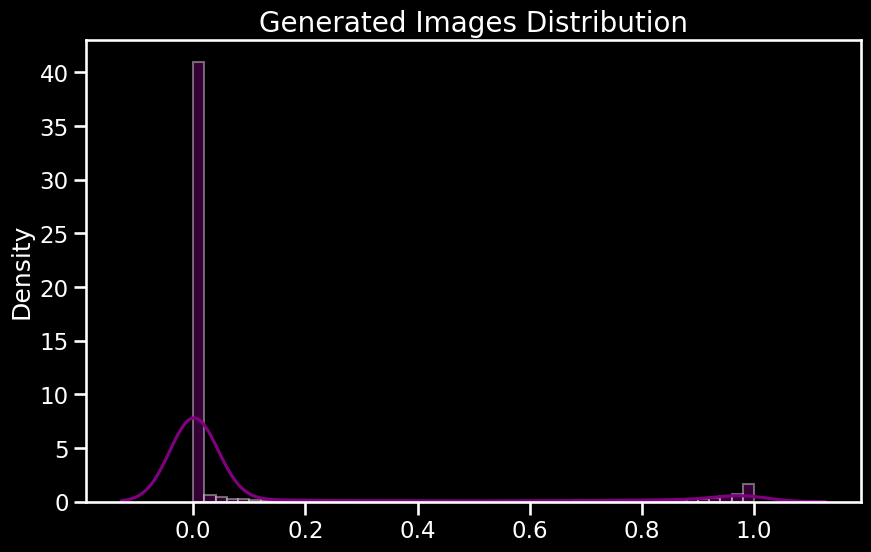

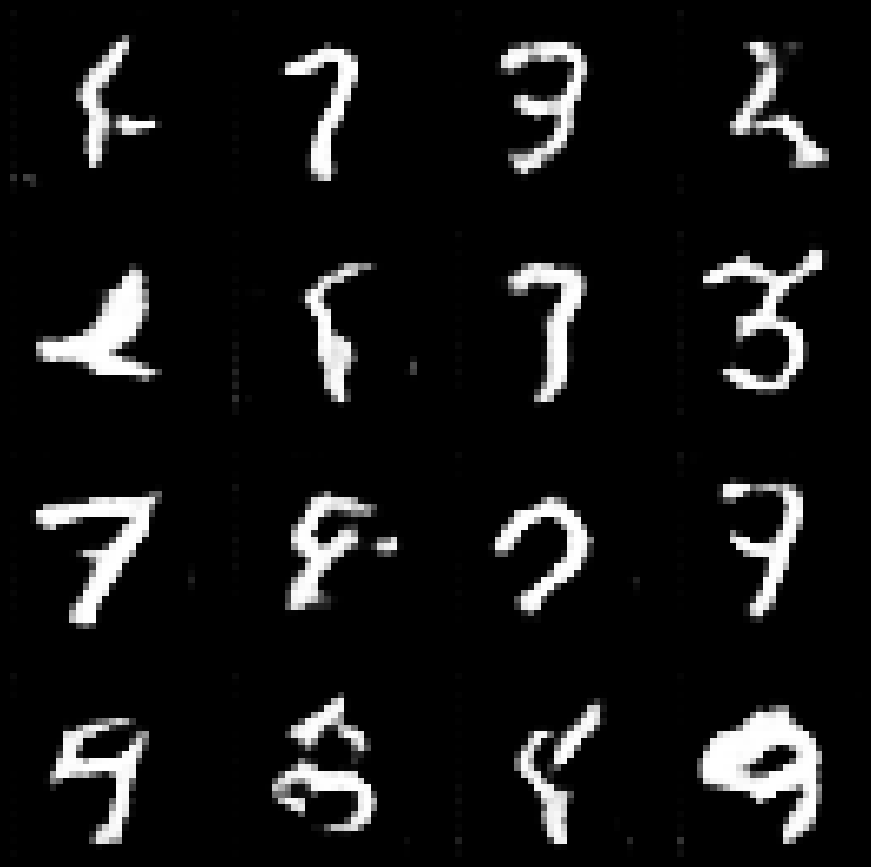

4/4 [==============================] - 0s 3ms/step
3200 [D loss: 0.414085, accuracy: 83.98%] [G loss: 1.737412]
1/1 [==============================] - 0s 19ms/step


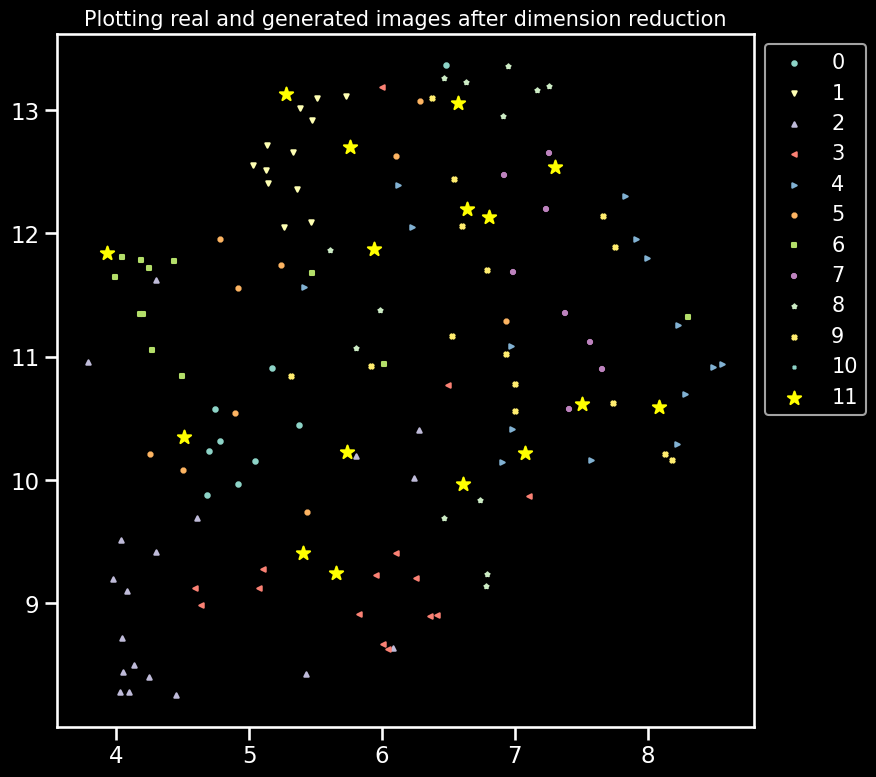

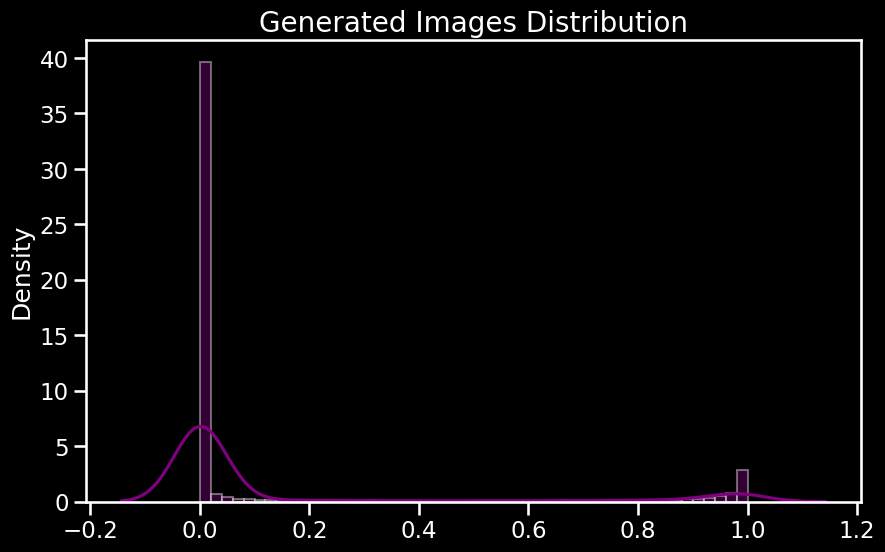

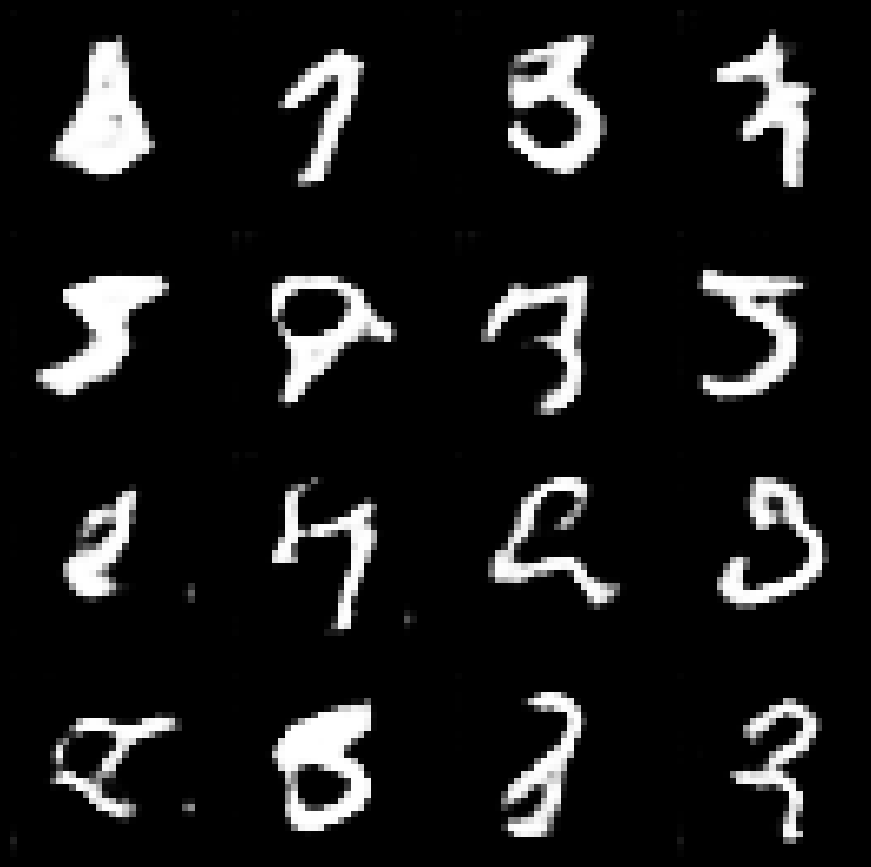

4/4 [==============================] - 0s 3ms/step


In [ ]:
# DCGAN training for a specified number of iterations
train(iterations, batch_size, sample_interval)

### Демонстрация сгенерированных изображений:

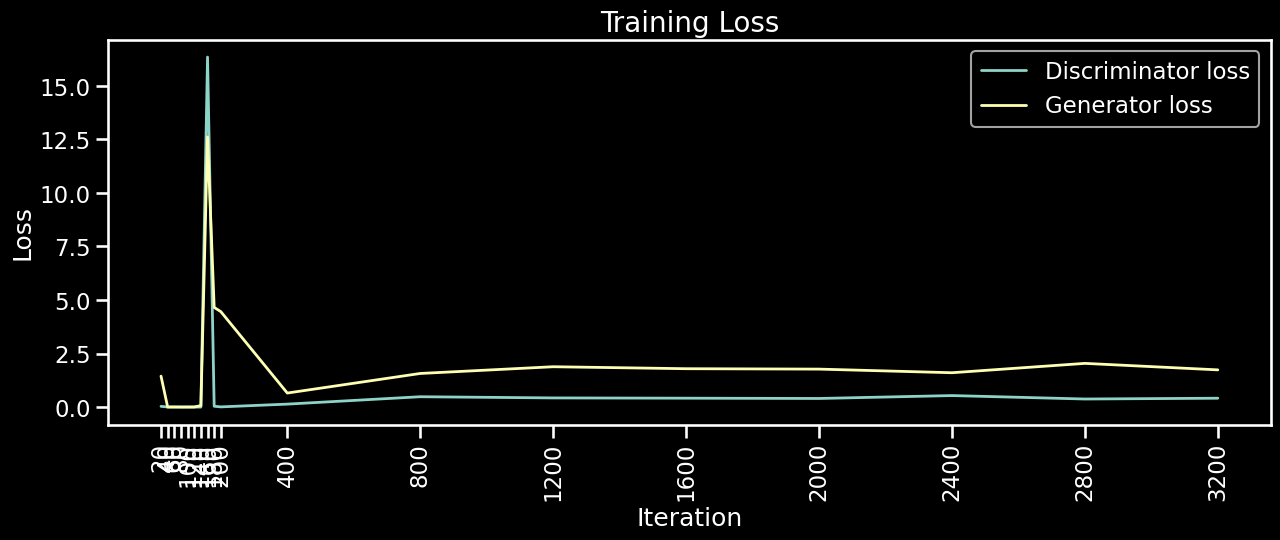

In [ ]:
losses = np.array(losses)

# Training loss graph of discriminant and generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss",linewidth=2)
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss",linewidth=2)

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Training Loss",fontsize = 20)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

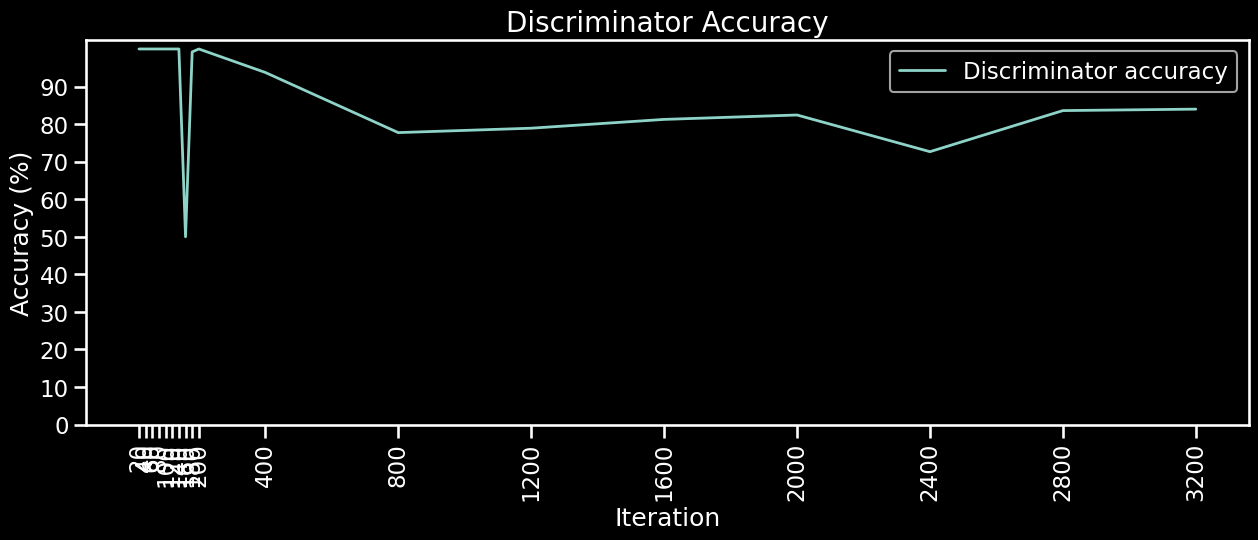

In [ ]:
accuracies = np.array(accuracies)

# Discriminator Accuracy Graph
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label="Discriminator accuracy",linewidth=2)

plt.xticks(iteration_checkpoints, rotation=90)
plt.yticks(range(0, 100, 10))

plt.title("Discriminator Accuracy",fontsize = 20)
plt.xlabel("Iteration")
plt.ylabel("Accuracy (%)")
plt.legend()

# **Задание №2.** Обучите генератор воспризводить сложные изображения. Датасет выберите по желанию. ([Пример](https://www.kaggle.com/competitions/cifar-10/data))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os
# import gdown
# from zipfile import ZipFile

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [ ]:
# os.makedirs("celeba_gan")

# url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
# output = "celeba_gan/data.zip"
# gdown.download(url, output, quiet=True)

# with ZipFile("celeba_gan/data.zip", "r") as zipobj:
#     zipobj.extractall("celeba_gan")

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    "/kaggle/input/cartoonset10k/cartoonset10k", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 10000 files belonging to 1 classes.


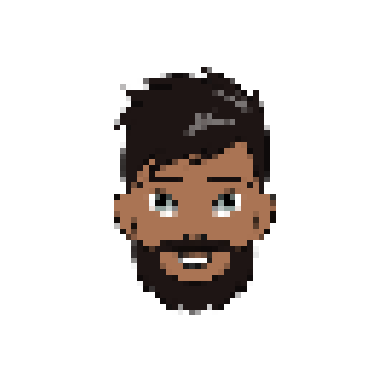

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape (Reshape)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 32, 32, 256)       0 

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):

        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        generated_images = self.generator(random_latent_vectors)

        combined_images = tf.concat([generated_images, real_images], axis=0)

        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Обучение дескриминатора
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        # Обучаем генератор (веса дескриминатора не обновляются)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [ ]:
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [ ]:
epochs = 50
gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/50
313/313 [==============================] - 64s 162ms/step - d_loss: 0.3050 - g_loss: 2.3959
Epoch 2/50
313/313 [==============================] - 43s 134ms/step - d_loss: 0.3159 - g_loss: 1.9140
Epoch 3/50
313/313 [==============================] - 44s 137ms/step - d_loss: 0.2965 - g_loss: 1.8670
Epoch 4/50
313/313 [==============================] - 43s 135ms/step - d_loss: 0.6207 - g_loss: 1.0310
Epoch 5/50
313/313 [==============================] - 43s 136ms/step - d_loss: 0.6949 - g_loss: 0.8357
Epoch 6/50
313/313 [==============================] - 44s 138ms/step - d_loss: 0.6487 - g_loss: 0.8759
Epoch 7/50
313/313 [==============================] - 44s 136ms/step - d_loss: 0.6122 - g_loss: 0.9319
Epoch 8/50
313/313 [==============================] - 44s 138ms/step - d_loss: 0.5878 - g_loss: 0.9777
Epoch 9/50
313/313 [==============================] - 44s 136ms/step - d_loss: 0.5996 - g_loss: 0.9702
Epoch 10/50
313/313 [==============================] - 43s 136ms/step - d

### Демонстрация сгенерированных изображений:

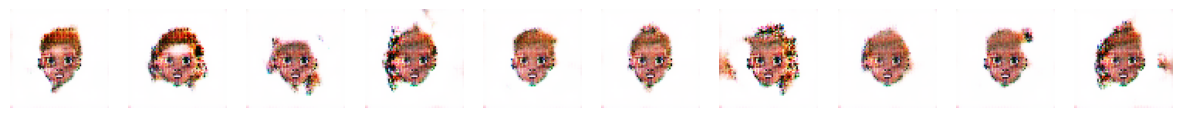

In [ ]:
import cv2
Ntest = 10
fig, ax = plt.subplots(1, Ntest, figsize=(15, 10))
#Результаты после первой эпохи
for i in range(Ntest):
    image = cv2.imread(f'/kaggle/working/generated_img_010_{i}.png')
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

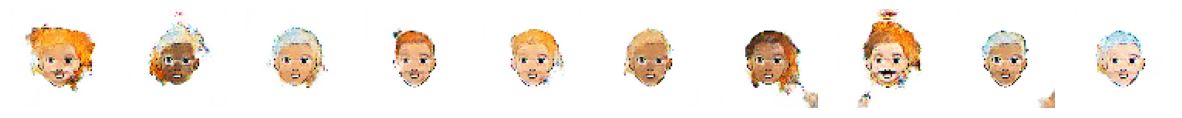

In [ ]:
import cv2
Ntest = 10
fig, ax = plt.subplots(1, Ntest, figsize=(15, 10))
#Результаты после первой эпохи
for i in range(Ntest):
    image = cv2.imread(f'/kaggle/working/generated_img_030_{i}.png')
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')

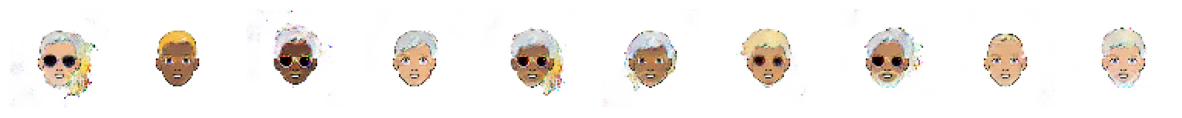

In [ ]:
import cv2
Ntest = 10
fig, ax = plt.subplots(1, Ntest, figsize=(15, 10))
#Результаты после первой эпохи
for i in range(Ntest):
    image = cv2.imread(f'/kaggle/working/generated_img_049_{i}.png')
    ax[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')